In [4]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree
import pandas as pd
import wandb
import time


%load_ext autoreload
%autoreload 2

%env XLA_FLAGS

jax.devices("gpu")

[cuda(id=0)]

In [5]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize":figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


## Analyse data from wandb

### length vs k

In [8]:
api = wandb.Api()
results = []
# t_run = tqdm(api.sweep("ddold/subspace_bezier_length_dnn/taa7hglw").runs)
for s in ["sk1xawa4", "z3sn12tg"]:
    t_run = tqdm(api.sweep(f"ddold/subspace_bezier_length_dnn/{s}").runs)
    t_run.set_description(s)
    for run in t_run:
        if run.state != 'finished':
            print(f"Skipping {run.name} because it is not finished")
            continue
        if run.config['curve_params']['k'] == 200:
            print(f"Skipping {run.name} because k == 200 ")
            continue
        t_run.set_postfix_str(run.name)
        # print(run.name)
        res = dict(id=run.id,
                    numSpace=run.config['curve_params']['k'],
                    dnnDepth=run.config['curve_params']['model_kwargs']['depth'],
                    dnnWidth=run.config['curve_params']['model_kwargs']['width'],
                    dnnActivation=run.config['curve_params']['model_kwargs']['activation'],
                n_samples=run.config['curve_params']['n_samples'],
                    weightDecay=run.config['curve_params']['weight_decay'],
                    seed=run.config['rng_seed'],
                    bezierLength=run.summary['bezier_length'],
                valid_curve_performance=run.summary['curve_performance'],
                curve_ll_last=run.summary['curve_ll_last'],
                curve_ll_best=run.summary['curve_ll_best'],

            )
        results.append(res)

df = pd.DataFrame(results)
df

z3sn12tg:   5%|▍         | 71/1458 [00:00<00:02, 647.86it/s]

Skipping light-sweep-1458 because k == 200 
Skipping elated-sweep-1457 because k == 200 
Skipping cosmic-sweep-1456 because k == 200 
Skipping morning-sweep-1455 because k == 200 
Skipping wobbly-sweep-1454 because k == 200 
Skipping silvery-sweep-1453 because k == 200 
Skipping azure-sweep-1452 because k == 200 
Skipping cool-sweep-1451 because k == 200 
Skipping glamorous-sweep-1450 because k == 200 
Skipping colorful-sweep-1449 because k == 200 
Skipping spring-sweep-1448 because k == 200 
Skipping treasured-sweep-1447 because k == 200 
Skipping whole-sweep-1446 because k == 200 
Skipping deft-sweep-1445 because k == 200 
Skipping giddy-sweep-1444 because k == 200 
Skipping neat-sweep-1443 because k == 200 
Skipping copper-sweep-1442 because k == 200 
Skipping ethereal-sweep-1441 because k == 200 
Skipping glorious-sweep-1440 because k == 200 
Skipping autumn-sweep-1439 because k == 200 
Skipping curious-sweep-1438 because k == 200 
Skipping kind-sweep-1437 because k == 200 
Skippin

z3sn12tg:  14%|█▍        | 204/1458 [00:00<00:02, 626.80it/s]

Skipping cosmic-sweep-1328 because k == 200 
Skipping unique-sweep-1327 because k == 200 
Skipping peach-sweep-1326 because k == 200 
Skipping dauntless-sweep-1325 because k == 200 
Skipping revived-sweep-1324 because k == 200 
Skipping apricot-sweep-1323 because k == 200 
Skipping expert-sweep-1322 because k == 200 
Skipping solar-sweep-1321 because k == 200 
Skipping kind-sweep-1320 because k == 200 
Skipping devoted-sweep-1319 because k == 200 
Skipping stilted-sweep-1318 because k == 200 
Skipping royal-sweep-1317 because k == 200 
Skipping ethereal-sweep-1316 because k == 200 
Skipping resilient-sweep-1315 because k == 200 
Skipping dandy-sweep-1314 because k == 200 
Skipping jumping-sweep-1313 because k == 200 
Skipping major-sweep-1312 because k == 200 
Skipping rich-sweep-1311 because k == 200 
Skipping drawn-sweep-1310 because k == 200 
Skipping neat-sweep-1309 because k == 200 
Skipping resilient-sweep-1308 because k == 200 
Skipping wobbly-sweep-1307 because k == 200 
Skippi

z3sn12tg:  23%|██▎       | 332/1458 [00:00<00:01, 596.29it/s]

Skipping magic-sweep-1198 because k == 200 
Skipping dutiful-sweep-1197 because k == 200 
Skipping helpful-sweep-1196 because k == 200 
Skipping elated-sweep-1195 because k == 200 
Skipping autumn-sweep-1194 because k == 200 
Skipping mild-sweep-1193 because k == 200 
Skipping comfy-sweep-1192 because k == 200 
Skipping easy-sweep-1191 because k == 200 
Skipping absurd-sweep-1190 because k == 200 
Skipping dazzling-sweep-1189 because k == 200 
Skipping comic-sweep-1188 because k == 200 
Skipping glad-sweep-1187 because k == 200 
Skipping glorious-sweep-1186 because k == 200 
Skipping glorious-sweep-1185 because k == 200 
Skipping rural-sweep-1184 because k == 200 
Skipping genial-sweep-1183 because k == 200 
Skipping dazzling-sweep-1182 because k == 200 
Skipping giddy-sweep-1181 because k == 200 
Skipping dainty-sweep-1180 because k == 200 
Skipping unique-sweep-1179 because k == 200 
Skipping genial-sweep-1178 because k == 200 
Skipping glowing-sweep-1177 because k == 200 
Skipping s

z3sn12tg:  31%|███       | 451/1458 [00:00<00:01, 579.83it/s, zesty-sweep-968]    

Skipping fluent-sweep-1078 because k == 200 
Skipping resilient-sweep-1077 because k == 200 
Skipping wild-sweep-1076 because k == 200 
Skipping sunny-sweep-1075 because k == 200 
Skipping silvery-sweep-1073 because k == 200 
Skipping wise-sweep-1074 because k == 200 
Skipping wise-sweep-1072 because k == 200 
Skipping balmy-sweep-1071 because k == 200 
Skipping wandering-sweep-1069 because k == 200 
Skipping misty-sweep-1070 because k == 200 
Skipping elated-sweep-1068 because k == 200 
Skipping noble-sweep-1067 because k == 200 
Skipping dry-sweep-1065 because k == 200 
Skipping silver-sweep-1066 because k == 200 
Skipping morning-sweep-1064 because k == 200 
Skipping lemon-sweep-1063 because k == 200 
Skipping dutiful-sweep-1062 because k == 200 
Skipping copper-sweep-1061 because k == 200 
Skipping sparkling-sweep-1060 because k == 200 
Skipping cosmic-sweep-1059 because k == 200 
Skipping clear-sweep-1058 because k == 200 
Skipping logical-sweep-1057 because k == 200 
Skipping fan

z3sn12tg: 100%|██████████| 1458/1458 [00:03<00:00, 408.43it/s, confused-sweep-1]       


,id,numSpace,dnnDepth,dnnWidth,dnnActivation,n_samples,weightDecay,seed,bezierLength,valid_curve_performance,curve_ll_last,curve_ll_best
0,6i6ucj29,40,20,10,elu,500,0.0,5,216.321503,1.238238,1.980681,1.609837
1,twmfozic,40,20,10,elu,500,0.0,4,225.011520,1.574225,1.932676,1.641761
2,bhh6owfq,40,20,10,elu,500,0.0,3,184.264771,1.635604,1.499118,1.497239
3,jxi3w8d2,40,20,10,elu,500,0.0,2,206.445404,0.708028,1.935908,1.474904
4,l5dxf2jm,40,20,10,elu,500,0.0,1,239.348679,1.665809,1.968051,1.434471
...,...,...,...,...,...,...,...,...,...,...,...,...
3397,nnm11mmv,70,3,10,relu,1,0.1,4,11.305218,-0.126417,0.162453,1.614352
3398,yt91687c,70,3,10,relu,1,0.1,3,11.666927,1.716899,1.446891,1.436557
3399,03pvc7xc,70,3,10,relu,1,0.1,2,11.426262,-2.167136,-2.154186,1.242772
3400,yxwsdii1,70,3,10,relu,1,0.1,1,10.197866,1.185333,0.892625,0.965417


In [9]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan]

,id,numSpace,dnnDepth,dnnWidth,dnnActivation,n_samples,weightDecay,seed,bezierLength,valid_curve_performance,curve_ll_last,curve_ll_best


In [10]:
df_clean = df[~idx_config_with_nan]
idx_ids = ['id', 'numSpace', 'dnnDepth', 'dnnWidth', 'dnnActivation', 'n_samples', 'weightDecay', 'seed']
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
for c in df_clean.columns:
    if c not in [*value_ids, 'id']:
        print(c, df_clean[c].unique())

Unique configuartions: 
numSpace [ 40  20  10   7   2 100  70]
dnnDepth [20 10  3]
dnnWidth [10]
dnnActivation ['elu' 'tanh' 'relu']
n_samples [500  20   1]
weightDecay [0.   0.01 0.1 ]
seed [5 4 3 2 1 0]


In [7]:
df.groupby(idx_ids[1:-1]).describe()

seed       \
                                                               count mean   
numSpace dnnDepth dnnWidth dnnActivation n_samples weightDecay              
2        3        10       elu           1         0.00          6.0  2.5   
                                                   0.01          6.0  2.5   
                                                   0.10          6.0  2.5   
                                         20        0.00          6.0  2.5   
                                                   0.01          6.0  2.5   
...                                                              ...  ...   
100      20       10       tanh          20        0.01          6.0  2.5   
                                                   0.10          6.0  2.5   
                                         500       0.00          6.0  2.5   
                                                   0.01          6.0  2.5   
                                                   0.10          6.0  2.5   

                                                                               \
                                                                     std  min   
numSpace dnnDepth dnnWidth dnnActivation n_samples weightDecay                  
2        3        10       elu           1         0.00         1.870829  0.0   
                                                   0.01         1.870829  0.0   
                                                   0.10         1.870829  0.0   
                                         20        0.00         1.870829  0.0   
                                                   0.01         1.870829  0.0   
...                                                                  ...  ...   
100      20       10       tanh          20        0.01         1.870829  0.0   
                                                   0.10         1.870829  0.0   
                                         500       0.00         1.870829  0.0   
                                                   0.01         1.870829  0.0   
                                                   0.10         1.870829  0.0   

                                                                           \
                                                                 25%  50%   
numSpace dnnDepth dnnWidth dnnActivation n_samples weightDecay              
2        3        10       elu           1         0.00         1.25  2.5   
                                                   0.01         1.25  2.5   
                                                   0.10         1.25  2.5   
                                         20        0.00         1.25  2.5   
                                                   0.01         1.25  2.5   
...                                                              ...  ...   
100      20       10       tanh          20        0.01         1.25  2.5   
                                                   0.10         1.25  2.5   
                                         500       0.00         1.25  2.5   
                                                   0.01         1.25  2.5   
                                                   0.10         1.25  2.5   

                                                                           \
                                                                 75%  max   
numSpace dnnDepth dnnWidth dnnActivation n_samples weightDecay              
2        3        10       elu           1         0.00         3.75  5.0   
                                                   0.01         3.75  5.0   
                                                   0.10         3.75  5.0   
                                         20        0.00         3.75  5.0   
                                                   0.01         3.75  5.0   
...                                                              ...  ...   
100      20       10       tanh          20        0.01         3.75  5.0   
 

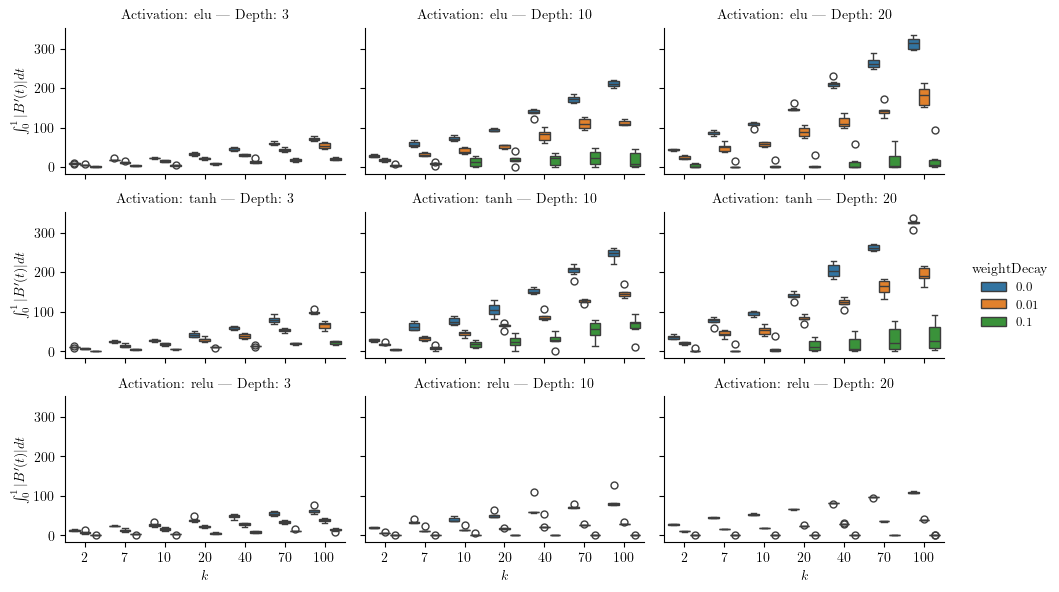

In [20]:
# fig, ax = plt.subplots(figsize=figsize)
df_subset = df_clean[df_clean['n_samples'] == 1]
g = sns.catplot(df_subset, col='dnnDepth', row="dnnActivation", x='numSpace',
                y='bezierLength', hue='weightDecay', dodge=True, palette='tab10', kind='box', height=figsize[1], aspect=figsize[0]/figsize[1])
# g.add_legend(title='Weight Decay')
g.set_ylabels(r"$\int_0^1 |B'(t)| dt$")
g.set_xlabels(r"$k$")
g.set_titles(col_template="Depth: {col_name}", row_template="Activation: {row_name}")
g.tight_layout()
# log scale
# g.set(yscale='log', xscale='log')

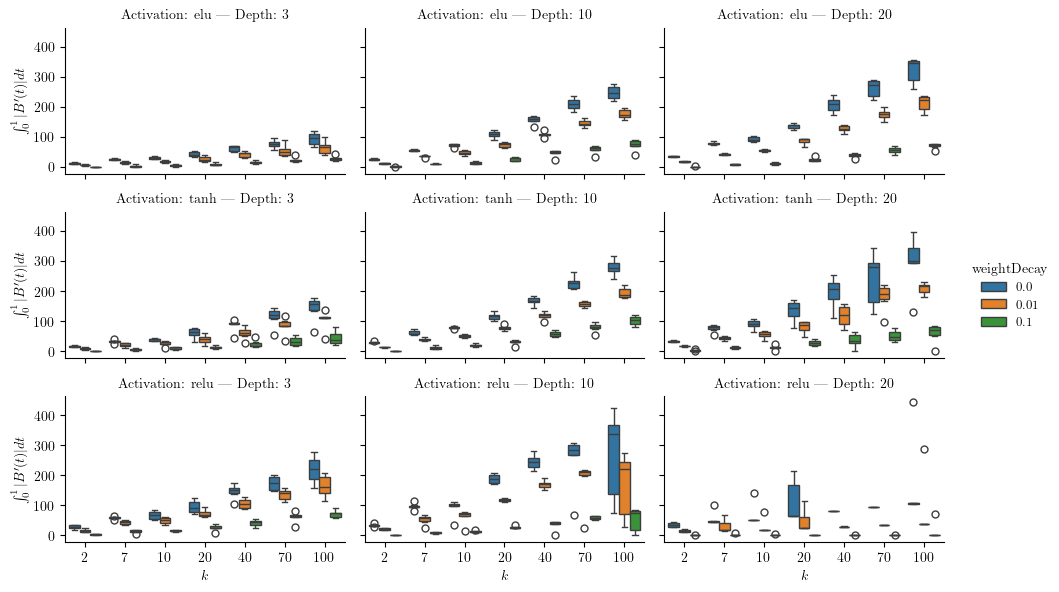

In [21]:
# fig, ax = plt.subplots(figsize=figsize)
df_subset = df_clean[df_clean['n_samples'] == 500]
g = sns.catplot(df_subset, col='dnnDepth', row="dnnActivation", x='numSpace',
                y='bezierLength', hue='weightDecay', dodge=True, palette='tab10', kind='box', height=figsize[1], aspect=figsize[0]/figsize[1])
# g.add_legend(title='Weight Decay')
g.set_ylabels(r"$\int_0^1 |B'(t)| dt$")
g.set_xlabels(r"$k$")
g.set_titles(col_template="Depth: {col_name}",
             row_template="Activation: {row_name}")
g.tight_layout()
# log scale
# g.set(yscale='log', xscale='log')
plt.savefig('figures/bezier_length_vs_k.pdf', bbox_inches='tight')

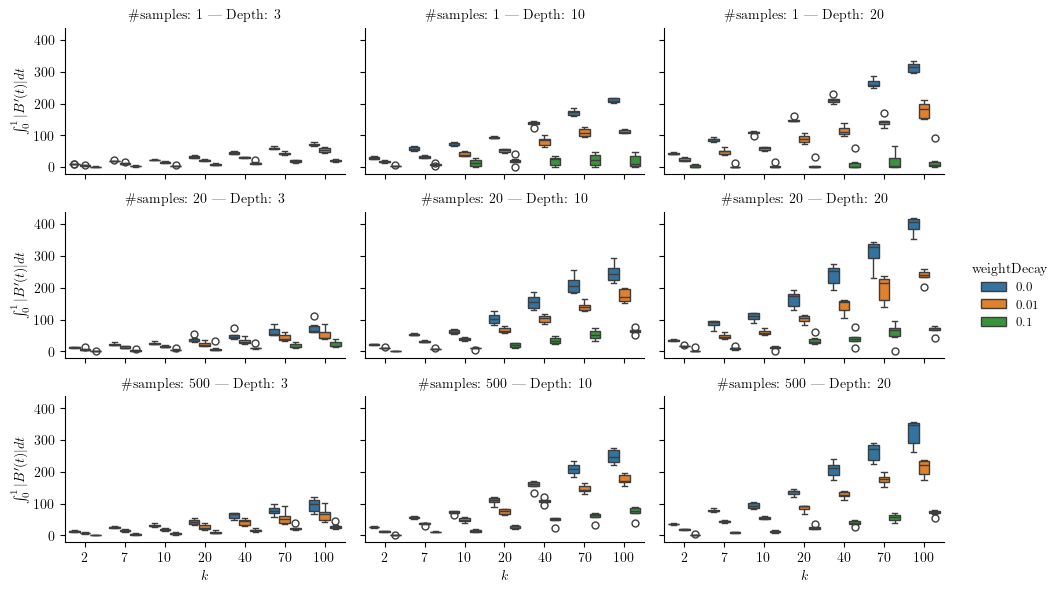

In [22]:
df_subset = df[df['dnnActivation'] == 'elu']
# fig, ax = plt.subplots(figsize=figsize)
g = sns.catplot(df_subset, col='dnnDepth', row="n_samples", x='numSpace',
                y='bezierLength', hue='weightDecay', dodge=True, palette='tab10', kind='box', height=figsize[1], aspect=figsize[0]/figsize[1])
# g.add_legend(title='Weight Decay')
g.set_ylabels(r"$\int_0^1 |B'(t)| dt$")
g.set_xlabels(r"$k$")
g.set_titles(col_template="Depth: {col_name}",
             row_template="\#samples: {row_name}")
g.tight_layout()
plt.savefig('figures/bezier_length_vs_k.pdf', bbox_inches='tight')

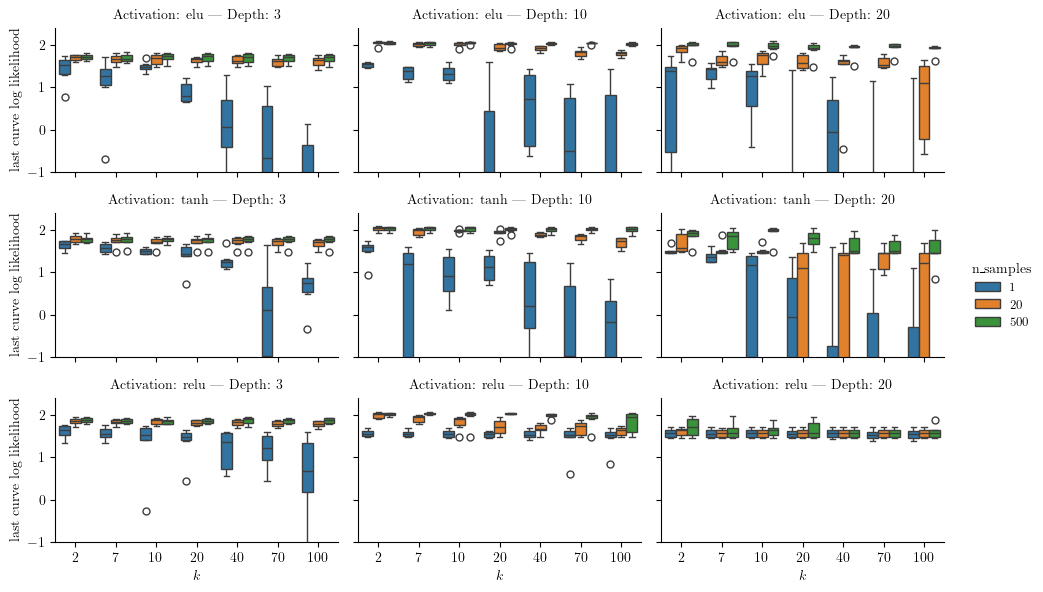

In [23]:
# fig, ax = plt.subplots(figsize=figsize)
df_subset = df[df['weightDecay'] == 0.]
g = sns.catplot(df_subset, col='dnnDepth', row="dnnActivation", x='numSpace',
                y='curve_ll_last', hue='n_samples', dodge=True, palette='tab10', kind='box', height=figsize[1], aspect=figsize[0]/figsize[1])
# g.add_legend(title='Weight Decay')
g.set_ylabels(r"last curve log likelihood")
g.set_xlabels(r"$k$")
g.set_titles(col_template="Depth: {col_name}",
             row_template="Activation: {row_name}")
# set y limit
g.set(ylim=(-1., 2.4))
g.tight_layout()
# plt.savefig('figures/bezier_length_vs_k.pdf', bbox_inches='tight')

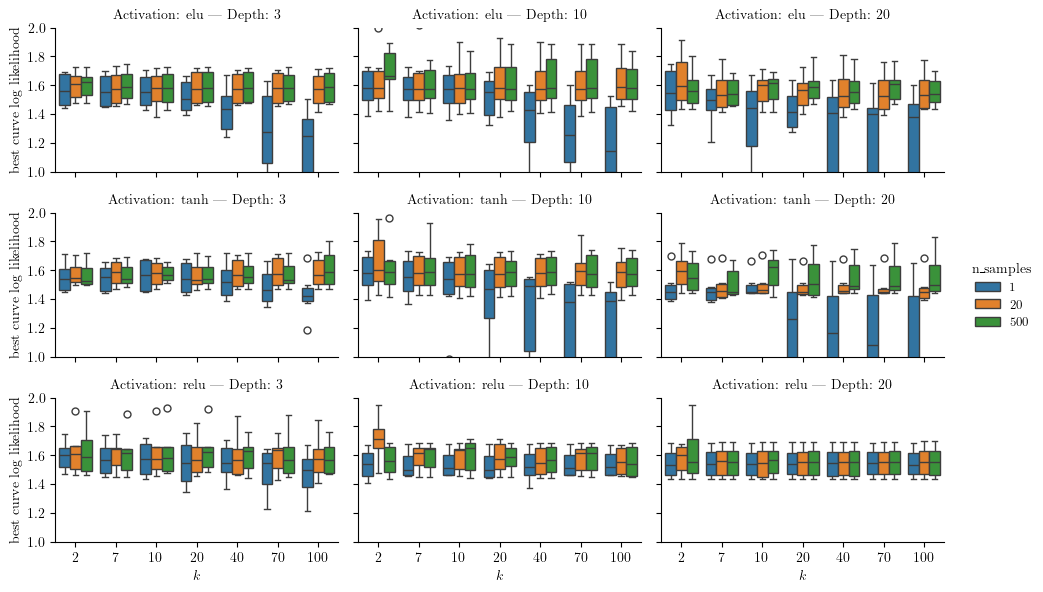

In [24]:
# fig, ax = plt.subplots(figsize=figsize)
# df_subset = df[df['weightDecay'] == 0.]
g = sns.catplot(df_subset, col='dnnDepth', row="dnnActivation", x='numSpace',
                y='curve_ll_best', hue='n_samples', dodge=True, palette='tab10', kind='box', height=figsize[1], aspect=figsize[0]/figsize[1])
# g.add_legend(title='Weight Decay')
g.set_ylabels(r"best curve log likelihood")
g.set_xlabels(r"$k$")
g.set_titles(col_template="Depth: {col_name}",
             row_template="Activation: {row_name}")
# set y limit
g.set(ylim=(1., 2.))
g.tight_layout()
plt.savefig('figures/bezier_length_vs_k.pdf', bbox_inches='tight')

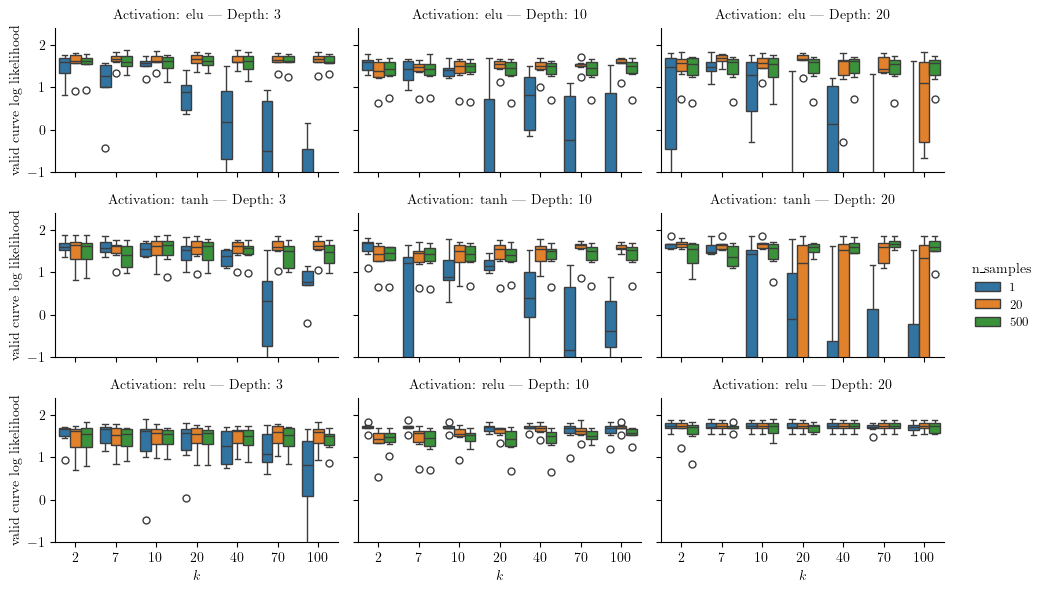

In [25]:
# fig, ax = plt.subplots(figsize=figsize)
# df_subset = df[df['weightDecay'] == 0.]
g = sns.catplot(df_subset, col='dnnDepth', row="dnnActivation", x='numSpace',
                y='valid_curve_performance', hue='n_samples', dodge=True, palette='tab10', kind='box', height=figsize[1], aspect=figsize[0]/figsize[1])
# g.add_legend(title='Weight Decay')
g.set_ylabels(r"valid curve log likelihood")
g.set_xlabels(r"$k$")
g.set_titles(col_template="Depth: {col_name}",
             row_template="Activation: {row_name}")
# set y limit
g.set(ylim=(-1., 2.4))
g.tight_layout()
plt.savefig('figures/bezier_length_vs_k.pdf', bbox_inches='tight')

In [ ]:
# from above analyse => we are save if we use around 20 samples to optimize the functional loss 

Linear regression (DNN depth 3): 0.45x + 2.22; R^2=0.905
Linear regression (DNN depth 10): 0.62x + 2.73; R^2=0.979
Linear regression (DNN depth 20): 0.61x + 3.22; R^2=0.971


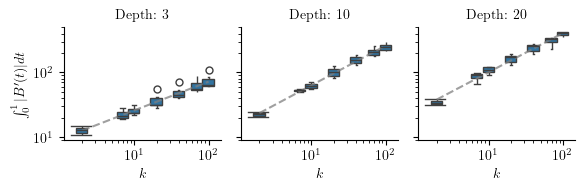

In [27]:
from scipy.stats import linregress

# fig, ax = plt.subplots(figsize=figsize)
df_subset = df[(df['weightDecay'] == 0.) & (df['dnnActivation'] == 'elu') & (df['n_samples'] == 20)]

w = 0.15
def width(p, w): 
    return 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

pos = df_subset['numSpace'].unique()
pos.sort()
widths = width(pos, w)

g = sns.catplot(df_subset, col='dnnDepth', x='numSpace',
                y='bezierLength', hue='dnnActivation', dodge=True, palette='tab10', kind='box', height=figsize[1], aspect=1, native_scale=True, widths=widths)
# g.add_legend(title='Weight Decay')
g.set_ylabels(r"$\int_0^1 |B'(t)| dt$")
g.set_xlabels(r"$k$")
g.set_titles(col_template="Depth: {col_name}",
             row_template="Activation: {row_name}")
# log scale

# add linear regression Line
for ax, depth in zip(g.axes.flat, [3,10,20]):
    df_depth3 = df_subset[df_subset['dnnDepth'] == depth]
    lin_reg = linregress(
        x=np.log(df_depth3['numSpace']), y=np.log(df_depth3['bezierLength']))
    print(f"Linear regression (DNN depth {depth}): {lin_reg.slope:.2f}x + {lin_reg.intercept:.2f}; R^2={lin_reg.rvalue**2:.3f}")
    pred = np.exp(np.log(pos)*lin_reg.slope + lin_reg.intercept)
    ax.plot(pos, pred, color='gray', linestyle='--', alpha=0.75)

# no legend
g._legend.remove()


g.set(yscale='log', xscale='log')
g.tight_layout()
plt.savefig('figures/bezier_length_vs_k.pdf', bbox_inches='tight')

In [29]:
df_subset.to_csv('BezierLength_end_elu.csv', index=False)

### Plotting length vs epochs

In [ ]:
print("Unique configuartions: ")
for c in df_clean.columns:
    if c not in [*value_ids, 'id']:
        print(c, df_clean[c].unique())

#### length vs epoch with new metrics and logging

In [11]:
api = wandb.Api()
results = []

for s in ["9ert25av", "dt842zq4"]: # adam
# for s in ["3v6lgdgf", "wbd1wu3v"]:  # sgd
# for s in ["xqdohkno",]:  # long adam
    t_run = tqdm(api.sweep(f"ddold/subspace_bezier_length_dnn/{s}").runs)
    t_run.set_description(s)
    for run in t_run:
        if run.state != 'finished':
            print(f"Skipping {run.name} because it is not finished")
            continue
        if (run.config['curve_params']['model_kwargs']['depth'] != 10) or \
        (run.config['curve_params']['model_kwargs']['activation'] != 'elu'):
            print(f"Skipping {run.name} because run not configured")
            continue
        t_run.set_postfix_str(run.name)
        # print(run.name)
        for art in run.logged_artifacts():
            if art.type == "metric":
                file = art.get_entry(f"{run.id}_length_metrics.npz").download(
                    root="./art_tmp")
                metrics = jnp.load(file, allow_pickle=True)
                frame = pd.DataFrame(dict(
                        loss = metrics['loss'],
                        curve_performance = metrics['curve_performance'],
                        length = metrics['length'],
                        l_bound = metrics['l_bound'],
                        u_bound = metrics['u_bound'],
                        gyra = metrics['gyra'],
                        center = metrics['center'],
                        mean_curve = metrics['mean_curv'],
                        epoch = metrics['epoch']))
        frame['Id'] = run.id
        frame['NumSpace'] = run.config['curve_params']['k']
        frame['DnnDepth'] = run.config['curve_params']['model_kwargs']['depth']
        frame['DnnWidth'] = run.config['curve_params']['model_kwargs']['width']
        frame['DnnActivation'] = run.config['curve_params']['model_kwargs']['activation']
        frame['WeightDecay'] = run.config['curve_params']['weight_decay']
        frame['N_samples'] = run.config['curve_params']['n_samples']
        frame['Seed'] = run.config['rng_seed']
        results.append(frame)

df_epoch = pd.concat(results, ignore_index=True)
df_epoch['valid_loss'] = -df_epoch['curve_performance']

dt842zq4: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s, curious-sweep-1] 


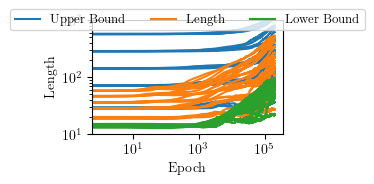

In [12]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='u_bound', estimator=None, units='Id', label="Upper Bound")
ax = sns.lineplot(data=df_epoch, x='epoch', y='length',
                  estimator=None, units='Id', ax=ax, label="Length")
ax = sns.lineplot(data=df_epoch, x='epoch', y='l_bound',
                  estimator=None, units='Id', ax=ax, label="Lower Bound")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Length")
ax.set_xlabel("Epoch")
ax.set_ylim(1e1, 1e3)

# Add legend for each lineplot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.tight_layout()

/home/daniel/miniconda3/envs/jax_torch/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/daniel/miniconda3/envs/jax_torch/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


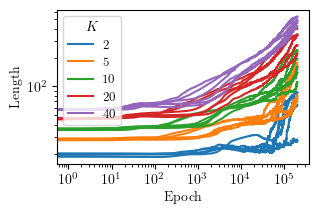

In [13]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='length',
                  hue="NumSpace", estimator=None, units='Id', palette='tab10')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Length")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

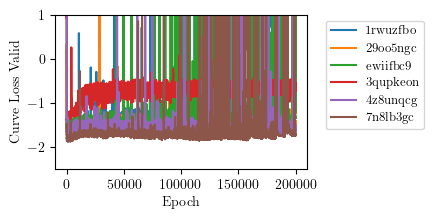

In [185]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='valid_loss', hue='Id')
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel("Curve Loss Valid")
plt.xlabel("Epoch")
plt.ylim(-2.5, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

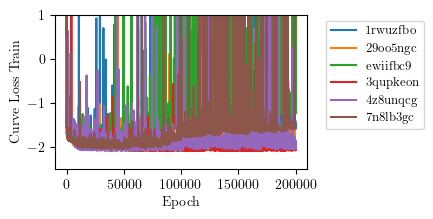

In [186]:
sns.lineplot(data=df_epoch, x='epoch', y='loss', hue='Id')
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel("Curve Loss Train")
plt.xlabel("Epoch")
plt.ylim(-2.5, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

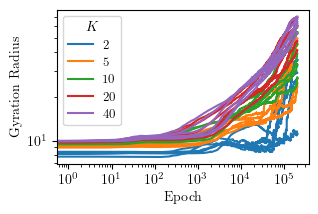

In [24]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='gyra',
                  hue="NumSpace", estimator=None, units='Id', palette='tab10')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Gyration Radius")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

/home/daniel/miniconda3/envs/jax3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/daniel/miniconda3/envs/jax3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


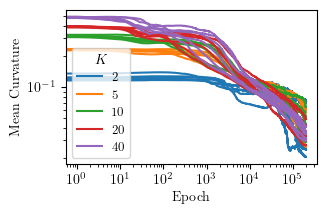

In [25]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='mean_curve', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Mean Curvature")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

/home/daniel/miniconda3/envs/jax3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/daniel/miniconda3/envs/jax3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


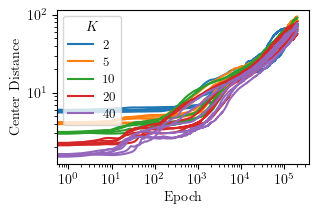

In [26]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='center', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Center Distance")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

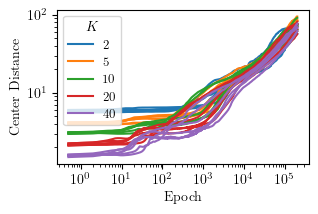

In [133]:
ax = sns.lineplot(data=grouped_df, x='epoch', y='center', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Center Distance")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

In [5]:
idx_ids = [col for col in df_epoch.columns if col[0].isupper()]
# idx_ids = ['id', 'Sampler', 'Space', 'PriorScale', 'TubeScale', 'Epsilon', 'Temperature', 'Activation', 'SubspaceDim', 'Seed', 'Fast']
value_ids = np.setdiff1d(df_epoch.columns.values, idx_ids)
print("Unique configuartions: ")
for c in df_epoch.columns:
    if c not in [*value_ids, 'Id']:
        print(c, df_epoch[c].unique())

Unique configuartions: 
NumSpace [20 40 10  5  2]
DnnDepth [10]
DnnWidth [10]
DnnActivation ['elu']
WeightDecay [0]
N_samples [500]
Seed [5 4 3 2 1 0]


In [11]:
df_epoch

,loss,curve_performance,length,l_bound,u_bound,gyra,center,mean_curve,epoch,Id,NumSpace,DnnDepth,DnnWidth,DnnActivation,WeightDecay,N_samples,Seed,valid_loss,epoch_group
0,-0.482768,1.589563,46.461506,13.672297,285.479065,9.837450,2.172469,0.388240,0,ojaud2iy,20,10,10,elu,0,500,5,-1.589563,1
1,-1.485766,1.611642,46.459389,13.670536,285.477234,9.837301,2.172094,0.388250,1,ojaud2iy,20,10,10,elu,0,500,5,-1.611642,1
2,-1.534046,1.623173,46.458755,13.670155,285.476532,9.837269,2.172206,0.388251,2,ojaud2iy,20,10,10,elu,0,500,5,-1.623173,2
3,-1.544924,1.623211,46.458603,13.670021,285.476379,9.837257,2.172198,0.388252,3,ojaud2iy,20,10,10,elu,0,500,5,-1.623211,3
4,-1.536412,1.624921,46.457825,13.669381,285.475677,9.837211,2.172200,0.388254,4,ojaud2iy,20,10,10,elu,0,500,5,-1.624921,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17999995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599995,irdq95ah,2,10,10,elu,0,500,0,NaN,599791
17999996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599996,irdq95ah,2,10,10,elu,0,500,0,NaN,599791
17999997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599997,irdq95ah,2,10,10,elu,0,500,0,NaN,599791
17999998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599998,irdq95ah,2,10,10,elu,0,500,0,NaN,599791


In [10]:
df_epoch_clean = df_epoch.dropna()
df_epoch_clean

,loss,curve_performance,length,l_bound,u_bound,gyra,center,mean_curve,epoch,Id,NumSpace,DnnDepth,DnnWidth,DnnActivation,WeightDecay,N_samples,Seed,valid_loss,epoch_group
0,-0.482768,1.589563e+00,46.461506,13.672297,285.479065,9.837450,2.172469,0.388240,0,ojaud2iy,20,10,10,elu,0,500,5,-1.589563e+00,1
1,-1.485766,1.611642e+00,46.459389,13.670536,285.477234,9.837301,2.172094,0.388250,1,ojaud2iy,20,10,10,elu,0,500,5,-1.611642e+00,1
2,-1.534046,1.623173e+00,46.458755,13.670155,285.476532,9.837269,2.172206,0.388251,2,ojaud2iy,20,10,10,elu,0,500,5,-1.623173e+00,2
3,-1.544924,1.623211e+00,46.458603,13.670021,285.476379,9.837257,2.172198,0.388252,3,ojaud2iy,20,10,10,elu,0,500,5,-1.623211e+00,3
4,-1.536412,1.624921e+00,46.457825,13.669381,285.475677,9.837211,2.172200,0.388254,4,ojaud2iy,20,10,10,elu,0,500,5,-1.624921e+00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16800001,1422.956299,-3.457744e+07,41.480938,38.391777,47.302269,16.247803,36.377232,0.030661,1,svxi1eka,2,10,10,elu,0,500,1,3.457744e+07,1
17400000,-0.901969,-1.833670e+01,18.586327,13.018822,27.524303,7.802617,5.770814,0.135358,0,irdq95ah,2,10,10,elu,0,500,0,1.833670e+01,1
17400001,15.350780,-6.200119e+02,18.659157,13.125651,27.559566,7.829932,6.015072,0.133992,1,irdq95ah,2,10,10,elu,0,500,0,6.200119e+02,1
17400002,640.342285,-9.370353e+04,26.778889,22.780771,33.930698,10.899444,17.565876,0.066227,2,irdq95ah,2,10,10,elu,0,500,0,9.370353e+04,2


In [12]:
df_epoch['epoch_group'] = (
    10**np.log10(df_epoch_clean['epoch']+1).round(3)).astype(int)
grouped_df = df_epoch_clean.set_index(
    idx_ids + ['epoch_group']).groupby(level=idx_ids + ['epoch_group']).mean()
grouped_df.reset_index(level='epoch_group', drop=True, inplace=True)
grouped_df.to_csv('bezier_length_metrics_diffK_sgd_compressed.csv', index=True)
grouped_df

loss  \
Id       NumSpace DnnDepth DnnWidth DnnActivation WeightDecay N_samples Seed                 
23dxwjay 5        10       10       elu           0           500       1        77.443069   
                                                                        1       690.405762   
                                                                        1     40521.796875   
2y8barbv 10       10       10       elu           0           500       1        32.325058   
                                                                        1        63.107872   
...                                                                                    ...   
zl9wxxlj 20       10       10       elu           0           500       1        14.180498   
ztcntb4h 5        10       10       elu           0           500       2        11.326546   
                                                                        2       200.567169   
                                                                        2       909.983704   
                                                                        2     50704.792969   

                                                                              curve_performance  \
Id       NumSpace DnnDepth DnnWidth DnnActivation WeightDecay N_samples Seed                      
23dxwjay 5        10       10       elu           0           500       1         -4.045796e+02   
                                                                        1         -4.026366e+04   
                                                                        1         -4.892481e+27   
2y8barbv 10       10       10       elu           0           500       1         -4.939706e+01   
                                                                        1         -6.581989e+01   
...                                                                                         ...   
zl9wxxlj 20       10       10       elu           0           500       1                  -inf   
ztcntb4h 5        10       10       elu           0           500       2         -1.086877e+02   
                                                                        2         -9.205609e+02   
                                                                        2         -5.290031e+04   
                                                                        2                  -inf   

                                                                                    length  \
Id       NumSpace DnnDepth DnnWidth DnnActivation WeightDecay N_samples Seed                 
23dxwjay 5        10       10       elu           0           500       1        28.022745   
                                                                        1        34.227261   
                                                                        1      1274.014526   
2y8barbv 10       10       10       elu           0           500       1        35.617813   
                                                                        1        35.570618   
...                                                                                    ...   
zl9wxxlj 20       10       10       elu           0           500       1        92.758781   
ztcntb4h 5        10       10       elu           0           500       2        28.426937   
                                                                        2        29.083492   
                                                                        2        49.818310   
                                                                        2     16648.464844   

                                                                                   l_bound  \
Id       NumSpace DnnDepth DnnWidth DnnActivation WeightDecay N_samples Seed                 
23dxwjay 5        10       10       elu           0           500       1        13.953959   
                                                                      

In [29]:
df_epoch.set_index(idx_ids+['epoch']).to_csv('bezier_length_metrics_diffK_adam.csv', index=True)

#### with long adam run and metric compression

In [117]:
api = wandb.Api()
results = []

# for s in ["xqdohkno", 's0cak6eg']:  # long adam
for s in ["eml6tnmw",]:  # long adam
    t_run = tqdm(api.sweep(f"ddold/subspace_bezier_length_dnn/{s}").runs)
    t_run.set_description(s)
    for run in t_run:
        if run.state != 'finished':
            print(f"Skipping {run.name} because it is not finished")
            continue
        if (run.config['curve_params']['model_kwargs']['depth'] != 10) or \
                (run.config['curve_params']['model_kwargs']['activation'] != 'elu'):
            print(f"Skipping {run.name} because run not configured")
            continue
        t_run.set_postfix_str(run.name)
        # print(run.name)
        for art in run.logged_artifacts():
            if art.type == "metric":
                frame = pd.read_csv(art.get_entry(f"{run.id}_length_metrics.csv").download(root="./art_tmp"))
        frame['Id'] = run.id
        frame['NumSpace'] = run.config['curve_params']['k']
        frame['DnnDepth'] = run.config['curve_params']['model_kwargs']['depth']
        frame['DnnWidth'] = run.config['curve_params']['model_kwargs']['width']
        frame['DnnActivation'] = run.config['curve_params']['model_kwargs']['activation']
        frame['WeightDecay'] = run.config['curve_params']['weight_decay']
        frame['N_samples'] = run.config['curve_params']['n_samples']
        frame['Seed'] = run.config['rng_seed']
        results.append(frame)

df_epoch = pd.concat(results, ignore_index=True)
df_epoch['valid_loss'] = -df_epoch['curve_performance']

eml6tnmw:  89%|████████▉ | 32/36 [00:07<00:00,  4.44it/s, warm-sweep-3]         

Skipping eternal-sweep-4 because it is not finished


eml6tnmw: 100%|██████████| 36/36 [00:07<00:00,  4.65it/s, celestial-sweep-1]


In [121]:
# to rolling window in log scale
# Convert x to log scale
df_epoch['epoch'] += 1
df_epoch['log_epoch'] = np.log(df_epoch['epoch'])

# Define log-spaced bins for rolling windows (powers of 2)
log_bins = np.logspace(
    np.log10(df_epoch['epoch'].min()), np.log10(df_epoch['epoch'].max()), num=300)

# Assign each x value to a log-bin
df_epoch['log_bin'] = pd.cut(df_epoch['epoch'], bins=log_bins, labels=False)

# Perform rolling aggregation within each log bin
df_epoch['log_rolling_loss'] = df_epoch.groupby(['log_bin', 'Id'])['loss'].transform('mean')
df_epoch['log_rolling_valid_loss'] = df_epoch.groupby(
    ['log_bin', 'Id'])['valid_loss'].transform('mean')
df_epoch

,Unnamed: 0,loss,curve_performance,length,l_bound,u_bound,gyra,center,mean_curve,relative_center,...,DnnWidth,DnnActivation,WeightDecay,N_samples,Seed,valid_loss,log_epoch,log_bin,log_rolling_loss,log_rolling_valid_loss
0,0,3.932613,-1.909220,19.983484,14.418747,29.038620,8.363375,5.746581,0.120407,0.302038,...,10,elu,0,20,5,1.909220,0.916291,NaN,NaN,NaN
1,1,1.168061,-1.250559,19.978150,14.417903,29.026814,8.360941,5.761540,0.120399,0.482299,...,10,elu,0,20,5,1.250559,1.386294,10.0,1.168061e+00,1.250559e+00
2,2,1.466761,-1.057617,19.980297,14.423171,29.024975,8.361600,5.779581,0.120338,0.590905,...,10,elu,0,20,5,1.057617,1.609438,15.0,1.466761e+00,1.057617e+00
3,3,1.028621,-0.876875,19.987139,14.432417,29.029156,8.364184,5.801268,0.120241,0.693530,...,10,elu,0,20,5,0.876875,1.791759,19.0,1.028621e+00,8.768748e-01
4,4,0.893966,-0.666509,19.997948,14.445150,29.038273,8.368388,5.825346,0.120112,0.792145,...,10,elu,0,20,5,0.666509,1.945910,22.0,8.939665e-01,6.665095e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047475,29923,257.798300,-253.087130,1911.506200,217.194870,5002.068400,181.389860,187.599640,0.012649,187.582430,...,10,elu,0,20,0,253.087130,14.507668,298.0,1.047564e+12,4.066276e+11
1047476,29924,251.210280,-247.898640,1914.542800,217.195420,5007.125000,181.575880,187.690020,0.012630,187.672790,...,10,elu,0,20,0,247.898640,14.507898,298.0,1.047564e+12,4.066276e+11
1047477,29925,243.654100,-244.887050,1917.388200,217.200400,5012.239000,181.745100,187.770950,0.012615,187.753780,...,10,elu,0,20,0,244.887050,14.508129,298.0,1.047564e+12,4.066276e+11
1047478,29926,235.562100,-237.144500,1919.826200,217.201280,5016.980500,181.894670,187.840450,0.012604,187.823330,...,10,elu,0,20,0,237.144500,14.508359,298.0,1.047564e+12,4.066276e+11


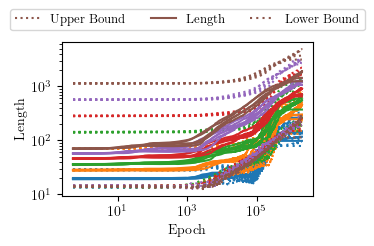

In [4]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='u_bound', hue="NumSpace", linestyle=':',
                  label="Upper Bound", legend=False, palette='tab10', estimator=None, units='Id')
ax = sns.lineplot(data=df_epoch, x='epoch', y='length', hue="NumSpace", linestyle='-',
                  ax=ax, label="Length", legend=False, palette='tab10', estimator=None, units='Id')
ax = sns.lineplot(data=df_epoch, x='epoch', y='l_bound', hue="NumSpace", linestyle=(0,(1,2)),
                  ax=ax, label="Lower Bound", legend=False, palette='tab10', estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Length")
ax.set_xlabel("Epoch")
# ax.set_ylim(1e1, 1e3)

# Add legend for each lineplot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3)
# plt.tight_layout()

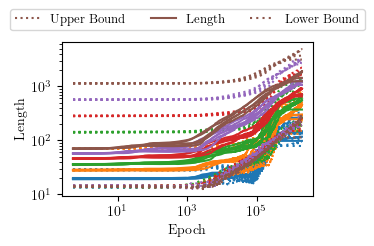

In [5]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='u_bound', hue="NumSpace", linestyle=':',
                  label="Upper Bound", legend=False, palette='tab10', estimator=None, units='Id')
ax = sns.lineplot(data=df_epoch, x='epoch', y='length', hue="NumSpace", linestyle='-',
                  ax=ax, label="Length", legend=False, palette='tab10', estimator=None, units='Id')
ax = sns.lineplot(data=df_epoch, x='epoch', y='l_bound', hue="NumSpace", linestyle=(0, (1, 2)),
                  ax=ax, label="Lower Bound", legend=False, palette='tab10', estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Length")
ax.set_xlabel("Epoch")
# ax.set_ylim(1e1, 1e3)

# Add legend for each lineplot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3)
# plt.tight_layout()

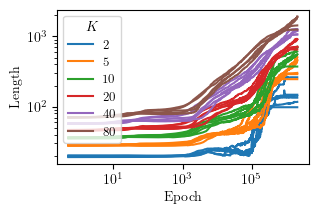

In [6]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='length',
                  hue="NumSpace", estimator=None, units='Id', palette='tab10')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Length")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

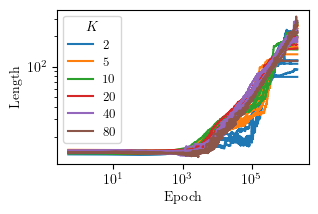

In [7]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='l_bound',
                  hue="NumSpace", estimator=None, units='Id', palette='tab10')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Length")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

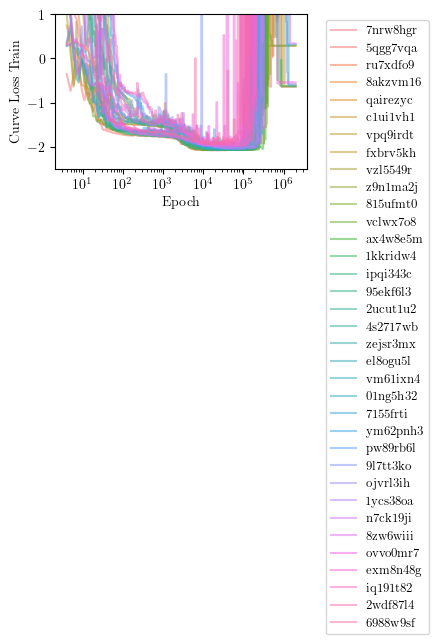

In [124]:
# df_epoch['loss_rolling'] = df_epoch['loss'].rolling(window=window).mean()
sns.lineplot(data=df_epoch, x='epoch',
             y='log_rolling_loss', hue='Id', alpha=0.5)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel("Curve Loss Train")
plt.xlabel("Epoch")
plt.ylim(-2.5, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log')

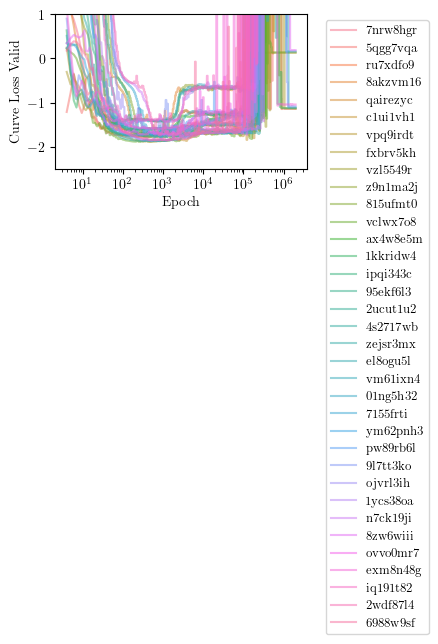

In [125]:
sns.lineplot(data=df_epoch, x='epoch',
             y='log_rolling_valid_loss', hue='Id', alpha=0.5)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel("Curve Loss Valid")
plt.xlabel("Epoch")
plt.ylim(-2.5, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log')

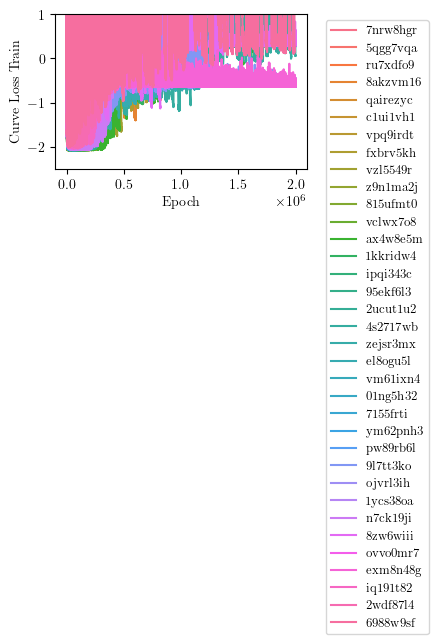

In [9]:
sns.lineplot(data=df_epoch, x='epoch', y='loss', hue='Id')
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel("Curve Loss Train")
plt.xlabel("Epoch")
plt.ylim(-2.5, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

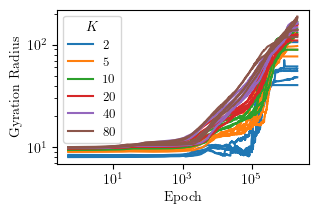

In [21]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='gyra',
                  hue="NumSpace", estimator=None, units='Id', palette='tab10')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Gyration Radius")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

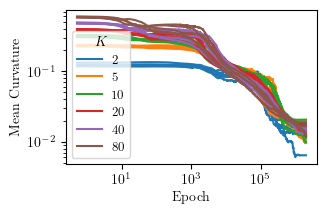

In [22]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='mean_curve', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Mean Curvature")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

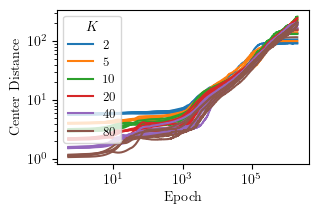

In [23]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='center', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Center Distance")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

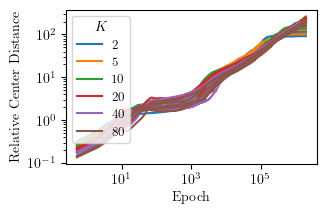

In [24]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='relative_center', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Relative Center Distance")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

(0.0, 100.0)

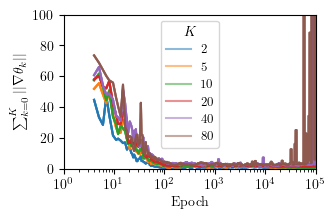

In [ ]:
df_epoch2 = df_epoch.copy(deep=True)
df_epoch2.rename(columns={'NumSpace': 'K'}, inplace=True)

df_epoch2['grad_norm_sum'] = df_epoch2.apply(
    lambda x: x['K']*x['grad_norm'], axis=1)
df_epoch2['log_rolling_grad_norm_sum'] = df_epoch2.groupby(
    ['log_bin', 'K'])['grad_norm_sum'].transform('mean')
df_epoch2['log_rolling_grad_norm_sum_std'] = df_epoch2.groupby(
    ['log_bin', 'K'])['grad_norm_sum'].transform('std')

ax = sns.lineplot(data=df_epoch2, x='epoch', y='log_rolling_grad_norm_sum', hue="K", palette='tab10',
                  estimator=None, units='Id', alpha=0.5)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r"$ \sum ^K_{k=0} ||\nabla \theta_k||$")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")
ax.set_xlim(1, 1e5)
ax.set_ylim(0, 100)

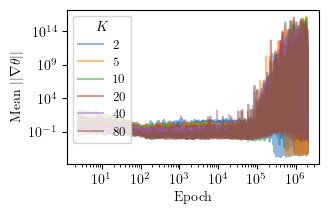

In [134]:
ax = sns.lineplot(data=df_epoch2, x='epoch', y='grad_norm', hue="K", palette='tab10',
                  estimator=None, units='Id', alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r"Mean $||\nabla\theta||$")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

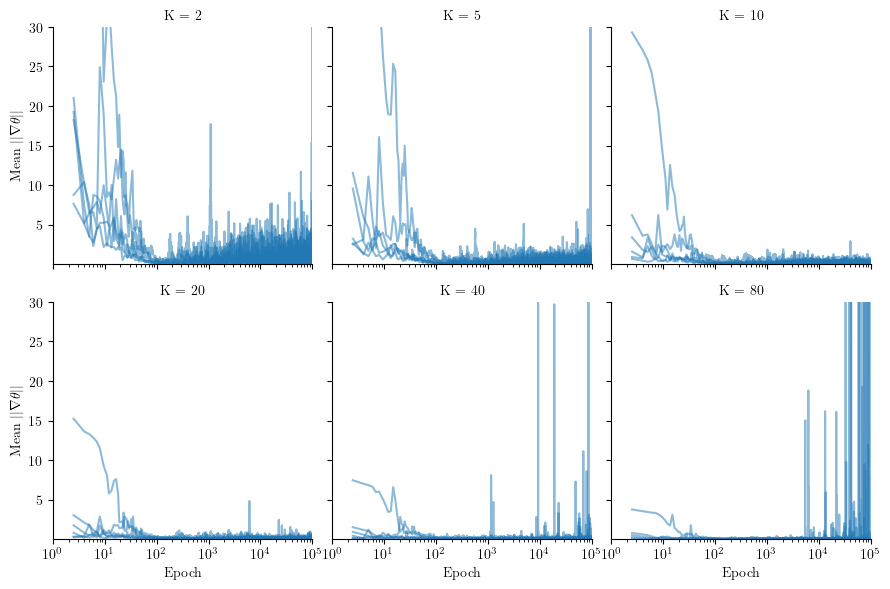

In [ ]:
facet = sns.FacetGrid(data=df_epoch2, col='K', col_wrap=3, height=3)
facet.map_dataframe(sns.lineplot, x='epoch', y='grad_norm',
                    estimator=None, units='Id', alpha=0.5)
# facet.set(yscale='log', xscale='log')
facet.set(xscale='log')
facet.set_ylabels(r"Mean $||\nabla\theta||$")
facet.set_xlabels("Epoch")
facet.set(xlim=(1, 1e5), ylim=(1e-3, 3e1))

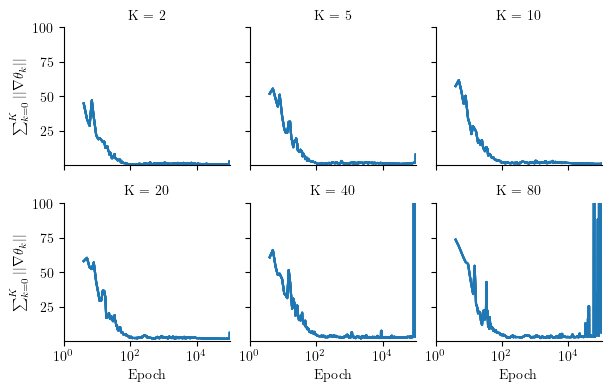

In [139]:

facet = sns.FacetGrid(data=df_epoch2, col='K', col_wrap=3, height=figsize[1])
facet.map_dataframe(sns.lineplot, x='epoch', y='log_rolling_grad_norm_sum',
                    estimator=None, units='Id')
# facet.set(yscale='log', xscale='log')
facet.set(xscale='log')
facet.set_ylabels(r"$ \sum^K_{k=0} ||\nabla\theta_k||$")
facet.set_xlabels("Epoch")
facet.set(xlim=(1, 1e5), ylim=(1e-3, 1e2))

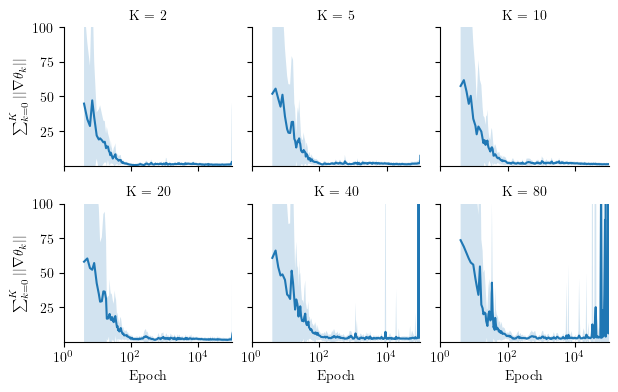

In [141]:
df_epoch2 = df_epoch.copy(deep=True)
df_epoch2.rename(columns={'NumSpace': 'K'}, inplace=True)
df_epoch2.drop(columns=['Unnamed: 0', 'Id', 'DnnActivation'], inplace=True)

df_epoch2['grad_norm_sum'] = df_epoch2.apply(
    lambda x: x['K']*x['grad_norm'], axis=1)
df_epoch2['log_rolling_grad_norm_sum'] = df_epoch2.groupby(
    ['log_bin', 'K'])['grad_norm_sum'].transform('mean')
df_epoch2['log_rolling_grad_norm_sum_std'] = df_epoch2.groupby(
    ['log_bin', 'K'])['grad_norm_sum'].transform('std')

df_epoch2 = df_epoch2.groupby(['log_bin', 'K']).mean().reset_index()

def plot_fill_between(data, **kwargs):
    plt.plot(data['epoch'], data['log_rolling_grad_norm_sum'])
    plt.fill_between(data['epoch'], 
                     data['log_rolling_grad_norm_sum'] - data['log_rolling_grad_norm_sum_std'],
                     data['log_rolling_grad_norm_sum'] + data['log_rolling_grad_norm_sum_std'], 
                     alpha=0.2)

facet = sns.FacetGrid(data=df_epoch2, col='K', col_wrap=3, height=figsize[1])
# facet.map_dataframe(sns.lineplot, x='epoch', y='log_rolling_grad_norm_sum')
facet.map_dataframe(plot_fill_between)
facet.set(xscale='log')
facet.set_ylabels(r"$ \sum^{K}_{k=0} ||\nabla\theta_k||$")
facet.set_xlabels("Epoch")
facet.set(xlim=(1, 1e5), ylim=(1e-3, 1e2))
plt.savefig('figures/bezier_length_vs_epoch_grad_norm.pdf', bbox_inches='tight')

In [60]:
df_epoch.drop(columns=['Unnamed: 0'], inplace=True)
idx_ids = [col for col in df_epoch.columns if col[0].isupper()]
# idx_ids = ['id', 'Sampler', 'Space', 'PriorScale', 'TubeScale', 'Epsilon', 'Temperature', 'Activation', 'SubspaceDim', 'Seed', 'Fast']
value_ids = np.setdiff1d(df_epoch.columns.values, idx_ids)
print("Unique configuartions: ")
for c in df_epoch.columns:
    if c not in [*value_ids, 'Id']:
        print(c, df_epoch[c].unique())

Unique configuartions: 
NumSpace [ 2 40 10  5 80 20]
DnnDepth [10]
DnnWidth [10]
DnnActivation ['elu']
WeightDecay [0]
N_samples [20]
Seed [3 2 1 0 5 4]


In [62]:
df_epoch_clean = df_epoch.dropna()
# df_epoch_clean.drop(columns=['Unnamed: 0'], inplace=True)
df_epoch_clean

,loss,curve_performance,length,l_bound,u_bound,gyra,center,mean_curve,relative_center,epoch,Id,NumSpace,DnnDepth,DnnWidth,DnnActivation,WeightDecay,N_samples,Seed,valid_loss
0,2.248535e+01,-1.918935e+01,19.398489,14.491865,27.516272,8.084381,5.610385,0.117318,0.307744,0.5,3pvvu2z5,2,10,10,elu,0,20,3,1.918935e+01
1,1.893641e+01,-1.552895e+01,19.421940,14.515294,27.541397,8.093723,5.631767,0.117098,0.511548,2.0,3pvvu2z5,2,10,10,elu,0,20,3,1.552895e+01
2,1.635882e+01,-1.452203e+01,19.452269,14.548366,27.570060,8.105598,5.660629,0.116776,0.653571,3.0,3pvvu2z5,2,10,10,elu,0,20,3,1.452203e+01
3,1.577995e+01,-1.427612e+01,19.475578,14.572870,27.593350,8.114794,5.687777,0.116543,0.779525,4.0,3pvvu2z5,2,10,10,elu,0,20,3,1.427612e+01
4,1.529878e+01,-1.482996e+01,19.502190,14.601985,27.618378,8.125206,5.722186,0.116262,0.905668,5.0,3pvvu2z5,2,10,10,elu,0,20,3,1.482996e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077403,2.346100e+14,-8.756502e+17,922.899600,245.425130,2294.311000,160.448670,225.070890,0.013023,225.037000,1998019.5,4dthg5tl,20,10,10,elu,0,20,0,8.756502e+17
1077404,5.397168e+02,-8.729120e+17,923.008800,245.432420,2294.999800,160.468540,225.123050,0.013024,225.089140,1998479.5,4dthg5tl,20,10,10,elu,0,20,0,8.729120e+17
1077405,5.726071e+15,-7.109367e+17,923.127400,245.467220,2295.735600,160.500720,225.286320,0.013023,225.252460,1998940.0,4dthg5tl,20,10,10,elu,0,20,0,7.109367e+17
1077406,8.997626e+14,-4.554378e+17,923.236000,245.527160,2296.470700,160.541610,225.556170,0.013023,225.522340,1999400.5,4dthg5tl,20,10,10,elu,0,20,0,4.554378e+17


In [63]:
df_epoch_clean.set_index(
    idx_ids+['epoch']).to_csv('bezier_length_metrics_diffK_adam_long.csv', index=True)

#### with wd

In [3]:
api = wandb.Api()
results = []

for s in ["ik0lcsno", ]:  # long adam with wd
    t_run = tqdm(api.sweep(f"ddold/subspace_bezier_length_dnn/{s}").runs)
    t_run.set_description(s)
    for run in t_run:
        if run.state != 'finished':
            print(f"Skipping {run.name} because it is not finished")
            continue
        if (run.config['curve_params']['model_kwargs']['depth'] != 10) or \
                (run.config['curve_params']['model_kwargs']['activation'] != 'elu'):
            print(f"Skipping {run.name} because run not configured")
            continue
        t_run.set_postfix_str(run.name)
        # print(run.name)
        for art in run.logged_artifacts():
            if art.type == "metric":
                frame = pd.read_csv(art.get_entry(
                    f"{run.id}_length_metrics.csv").download(root="./art_tmp"))
        frame['Id'] = run.id
        frame['NumSpace'] = run.config['curve_params']['k']
        frame['DnnDepth'] = run.config['curve_params']['model_kwargs']['depth']
        frame['DnnWidth'] = run.config['curve_params']['model_kwargs']['width']
        frame['DnnActivation'] = run.config['curve_params']['model_kwargs']['activation']
        frame['WeightDecay'] = run.config['curve_params']['weight_decay']
        frame['N_samples'] = run.config['curve_params']['n_samples']
        frame['Seed'] = run.config['rng_seed']
        results.append(frame)

df_epoch = pd.concat(results, ignore_index=True)
df_epoch['valid_loss'] = -df_epoch['curve_performance']

ik0lcsno: 100%|██████████| 72/72 [00:17<00:00,  4.05it/s, spring-sweep-1]    


In [11]:
df_epoch.drop(columns=['Unnamed: 0'], inplace=True)
idx_ids = [col for col in df_epoch.columns if col[0].isupper()]
# idx_ids = ['id', 'Sampler', 'Space', 'PriorScale', 'TubeScale', 'Epsilon', 'Temperature', 'Activation', 'SubspaceDim', 'Seed', 'Fast']
value_ids = np.setdiff1d(df_epoch.columns.values, idx_ids)
print("Unique configuartions: ")
for c in df_epoch.columns:
    if c not in [*value_ids, 'Id']:
        print(c, df_epoch[c].unique())

Unique configuartions: 
NumSpace [ 2  5 10 20 40 80]
DnnDepth [10]
DnnWidth [10]
DnnActivation ['elu']
WeightDecay [0.01 0.1 ]
N_samples [20]
Seed [5 4 3 2 1 0]


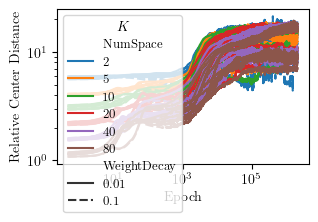

In [12]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='center', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id', style='WeightDecay')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Relative Center Distance")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

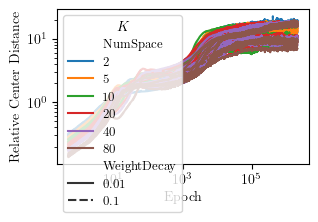

In [4]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='relative_center', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id', style='WeightDecay')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Relative Center Distance")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

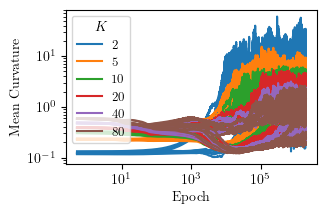

In [6]:
ax = sns.lineplot(data=df_epoch, x='epoch', y='mean_curve', hue="NumSpace", palette='tab10',
                  estimator=None, units='Id')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Mean Curvature")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

KeyboardInterrupt: 

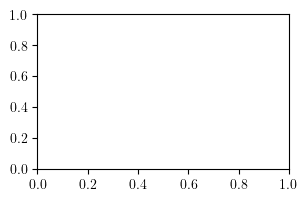

In [17]:
df_mean = df_epoch.set_index(idx_ids).groupby(['NumSpace', 'WeightDecay', 'epoch']).mean()
ax = sns.lineplot(data=df_mean.reset_index(), x='epoch', y='mean_curve', hue="NumSpace", palette='tab10')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Mean Curvature")
ax.set_xlabel("Epoch")
ax.legend(title=r"$K$")

In [19]:
df_epoch

,loss,curve_performance,length,l_bound,u_bound,gyra,center,mean_curve,relative_center,epoch,Id,NumSpace,DnnDepth,DnnWidth,DnnActivation,WeightDecay,N_samples,Seed,valid_loss
0,3.918707,-1.902483,19.980871,14.416899,29.034771,8.362278,5.745656,0.120423,0.302365,0.5,qdogu1lz,2,10,10,elu,0.01,20,5,1.902483
1,1.167560,-1.240091,19.972733,14.414133,29.018763,8.358665,5.759955,0.120431,0.482963,2.0,qdogu1lz,2,10,10,elu,0.01,20,5,1.240091
2,1.465671,-1.046219,19.973015,14.418118,29.014126,8.358539,5.777595,0.120379,0.591775,3.0,qdogu1lz,2,10,10,elu,0.01,20,5,1.046219
3,1.024959,-0.867877,19.977962,14.426072,29.015446,8.360325,5.798856,0.120292,0.694564,4.0,qdogu1lz,2,10,10,elu,0.01,20,5,0.867877
4,0.892469,-0.662073,19.986826,14.437468,29.021648,8.363711,5.822489,0.120176,0.793291,5.0,qdogu1lz,2,10,10,elu,0.01,20,5,0.662073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154811,-1.801044,1.760724,39.705190,5.737672,57.967323,3.271692,9.274374,0.716026,9.320593,1998019.5,0tjia2pj,80,10,10,elu,0.10,20,0,-1.760724
2154812,-1.794246,1.760793,40.413296,5.800028,61.123700,3.273616,9.284266,0.730482,9.329541,1998479.5,0tjia2pj,80,10,10,elu,0.10,20,0,-1.760793
2154813,-1.805339,1.762277,39.957340,5.647330,60.961470,3.198532,9.314352,0.737199,9.360168,1998940.0,0tjia2pj,80,10,10,elu,0.10,20,0,-1.762277
2154814,-1.802453,1.768321,38.658794,5.717352,57.718613,3.096909,9.338662,0.749001,9.385314,1999400.5,0tjia2pj,80,10,10,elu,0.10,20,0,-1.768321


In [18]:
df_epoch_clean = df_epoch.dropna()
# df_epoch_clean.drop(columns=['Unnamed: 0'], inplace=True)
df_epoch_clean

,loss,curve_performance,length,l_bound,u_bound,gyra,center,mean_curve,relative_center,epoch,Id,NumSpace,DnnDepth,DnnWidth,DnnActivation,WeightDecay,N_samples,Seed,valid_loss
0,3.918707,-1.902483,19.980871,14.416899,29.034771,8.362278,5.745656,0.120423,0.302365,0.5,qdogu1lz,2,10,10,elu,0.01,20,5,1.902483
1,1.167560,-1.240091,19.972733,14.414133,29.018763,8.358665,5.759955,0.120431,0.482963,2.0,qdogu1lz,2,10,10,elu,0.01,20,5,1.240091
2,1.465671,-1.046219,19.973015,14.418118,29.014126,8.358539,5.777595,0.120379,0.591775,3.0,qdogu1lz,2,10,10,elu,0.01,20,5,1.046219
3,1.024959,-0.867877,19.977962,14.426072,29.015446,8.360325,5.798856,0.120292,0.694564,4.0,qdogu1lz,2,10,10,elu,0.01,20,5,0.867877
4,0.892469,-0.662073,19.986826,14.437468,29.021648,8.363711,5.822489,0.120176,0.793291,5.0,qdogu1lz,2,10,10,elu,0.01,20,5,0.662073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154811,-1.801044,1.760724,39.705190,5.737672,57.967323,3.271692,9.274374,0.716026,9.320593,1998019.5,0tjia2pj,80,10,10,elu,0.10,20,0,-1.760724
2154812,-1.794246,1.760793,40.413296,5.800028,61.123700,3.273616,9.284266,0.730482,9.329541,1998479.5,0tjia2pj,80,10,10,elu,0.10,20,0,-1.760793
2154813,-1.805339,1.762277,39.957340,5.647330,60.961470,3.198532,9.314352,0.737199,9.360168,1998940.0,0tjia2pj,80,10,10,elu,0.10,20,0,-1.762277
2154814,-1.802453,1.768321,38.658794,5.717352,57.718613,3.096909,9.338662,0.749001,9.385314,1999400.5,0tjia2pj,80,10,10,elu,0.10,20,0,-1.768321


In [20]:
df_epoch_clean.set_index(
    idx_ids+['epoch']).to_csv('bezier_length_metrics_diffK_adam_long_wd.csv', index=True)

### Izmailov curve length

In [18]:
from src.jax_subspace_curve import bezier_coeff_fn
import pickle

k = 2
bezier_coeff_inv = bezier_coeff_fn(k)
# bezier_coeff = bezier_coeff_fn(config['curve_params']['k'] + 1)


def get_d_bezier(t):
    coeff = jax.vmap(bezier_coeff_inv)(t)

    def clousure(cp):
        n = cp.shape[0] - 1
        cp_diff = cp[1:] - cp[:-1]
        return jnp.einsum('tj,j...->t...', coeff, cp_diff) * n
    return clousure


@jit
def bezier_length(cp):
    t = jnp.linspace(0, 1, 1000)
    d_bezier = get_d_bezier(t)
    d_t = jnp.linalg.norm(d_bezier(cp), axis=-1)
    length = jax.scipy.integrate.trapezoid(d_t, t)
    return length


path = "./izmailov_curve_points/trained_curve_points_izmailov/trained_curve_points_izmailov/"
def comp_izmai_length(ds, seed):
    with open(f"{path}/{ds}/{seed}/trained_curve_params_dim2_{ds}.pkl", "rb") as f:
        trained_curve_params = pickle.load(f)
    cp_w = pytree_to_matrix(trained_curve_params, k)
    return bezier_length(cp_w)

In [24]:
import pandas as pd

lengths = []
for ds in os.listdir(path):
    ds_path = os.path.join(path, ds)
    if os.path.isdir(ds_path):
        for seed in os.listdir(ds_path):
            seed_path = os.path.join(ds_path, seed)
            if os.path.isdir(seed_path):
                print(f"Dataset: {ds}, Seed: {seed}")
                length = comp_izmai_length(ds, seed)
                lengths.append({'Dataset': ds, 'Seed': seed, 'Length': length})

df_lengths = pd.DataFrame(lengths)
df_lengths

Dataset: yacht, Seed: 2
Dataset: yacht, Seed: 1
Dataset: yacht, Seed: 4
Dataset: yacht, Seed: 0
Dataset: yacht, Seed: 3
Dataset: bikesharing, Seed: 2
Dataset: bikesharing, Seed: 1
Dataset: bikesharing, Seed: 4
Dataset: bikesharing, Seed: 0
Dataset: bikesharing, Seed: 3
Dataset: energy, Seed: 2
Dataset: energy, Seed: 1
Dataset: energy, Seed: 4
Dataset: energy, Seed: 0
Dataset: energy, Seed: 3
Dataset: airfoil, Seed: 2
Dataset: airfoil, Seed: 1
Dataset: airfoil, Seed: 4
Dataset: airfoil, Seed: 0
Dataset: airfoil, Seed: 3
Dataset: concrete, Seed: 2
Dataset: concrete, Seed: 1
Dataset: concrete, Seed: 4
Dataset: concrete, Seed: 0
Dataset: concrete, Seed: 3


,Dataset,Seed,Length
0,yacht,2,37.12854
1,yacht,1,46.638184
2,yacht,4,42.634045
3,yacht,0,44.963936
4,yacht,3,54.255028
5,bikesharing,2,72.30068
6,bikesharing,1,120.31207
7,bikesharing,4,152.35994
8,bikesharing,0,135.30423
9,bikesharing,3,88.99197


In [31]:
# df_lengths['Length'] = df_lengths['Length'].astype(float)
grouped = df_lengths.groupby('Dataset')['Length'].agg(['mean', 'std'])
grouped['Length'] = grouped.apply(
    lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)
grouped.drop(columns=['mean', 'std'])

,Length
Dataset,
airfoil,51.94 ± 9.52
bikesharing,113.85 ± 32.90
concrete,60.82 ± 9.94
energy,61.17 ± 24.31
yacht,45.12 ± 6.24


## Train example
train curve model and log curve length

### Load data

Data shapes: (70, 1) (70,) (33, 1) (33,)


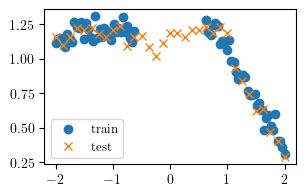

In [4]:
# load data
def load_data():
    data = jnp.load('regression_data.npz')
    x = jnp.array(data['x'])
    y = jnp.array(data['y'])
    x_test = jnp.array(data['xt'])
    y_test = jnp.array(data['yt'])
    return x, y, x_test, y_test
x, y, x_test, y_test = load_data()
plt.plot(x, y, 'o', label='train')
plt.plot(x_test, y_test, 'x', label='test')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test.shape, y_test.shape)

### Define model structure

In [5]:
from src.jax_test_model import MLPModel
from src.jax_subspace_curve import bezier_coeff_fn

config = {
        'curve_params': {'k': 10,
                         'model_kwargs': {'depth': 3, 'width': 10, 'activation': 'relu'},
                         'n_samples': 500,
                         'lr': 0.01,
                         'num_epochs': 10000,
                         'weight_decay': 0.0,
                         },
        'rng_seed': 10
    }


bezier_coeff_inv = bezier_coeff_fn(config['curve_params']['k'])
# bezier_coeff = bezier_coeff_fn(config['curve_params']['k'] + 1)

def get_d_bezier(t):
    coeff = jax.vmap(bezier_coeff_inv)(t)
    def clousure(cp):
        n = cp.shape[0] - 1
        cp_diff = cp[1:] - cp[:-1]
        return jnp.einsum('tj,j...->t...', coeff, cp_diff) * n
    return clousure

@jit
def bezier_length(cp):
    t = jnp.linspace(0, 1, 1000)
    d_bezier = get_d_bezier(t)
    d_t = jnp.linalg.norm(d_bezier(cp), axis=-1)
    length = jax.scipy.integrate.trapezoid(d_t, t)
    return length

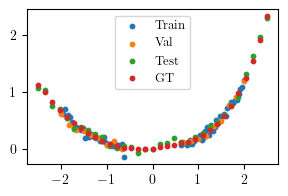

In [6]:
# Generate data by using the model itself
def gen_data(rng_seed, curve_params, **kwargs):
    rng_key = random.PRNGKey(rng_seed + 1133)
    x = jnp.linspace(-2, 2, 100)
    x = x[(jnp.abs(x) > 0.6)].reshape(-1, 1)

    # define ground trouth model
    rng_key, rng_init = random.split(rng_key)
    model_gen = MLPModel(**curve_params['model_kwargs'])
    params = model_gen.init(rng_init, x)

    # generate train data
    y_gt = model_gen.apply(params, x).squeeze()
    rng_key, rng = random.split(rng_key)
    y = y_gt + jax.random.normal(rng, y_gt.shape) * 0.05

    # generate valid data
    x_val = jnp.linspace(-2, 2, 25)
    x_val = x_val[(jnp.abs(x_val) > 0.6)].reshape(-1, 1)
    y_gt_val = model_gen.apply(params, x_val).squeeze()
    rng_key, rng = random.split(rng_key)
    y_val = y_gt_val + jax.random.normal(rng, y_gt_val.shape) * 0.05

    xt = jnp.linspace(-2.5, 2.5, 33).reshape(-1, 1)
    rng_key, rng = random.split(rng_key)
    y_gtt = model_gen.apply(params, xt).squeeze()
    yt = y_gtt + jax.random.normal(rng, y_gtt.shape) * 0.05

    return x, y, x_val, y_val, xt, yt, y_gtt

x, y, x_val, y_val, xt, yt, y_gt = gen_data(**config)
plt.scatter(x.flatten(), y.flatten(), label="Train", s=10)
plt.scatter(x_val.flatten(), y_val.flatten(), label="Val", s=10)
plt.scatter(xt.flatten(), yt.flatten(), label="Test", s=10)
plt.scatter(xt.flatten(), y_gt.flatten(), label="GT", s=10)
plt.legend()

### Train using adam and compute expectation with 10 samples

In [7]:
def get_mean_ll(model, x,y, t_space):
    def mean_ll(params):
        nll = model.nll(params,t_space, x, y).mean()
        return -nll
    return mean_ll


@jit
def mean_curvature(cp):
    tt = jnp.linspace(0, 1, 1000)
    _, d_bezier = bezier_curve(cp.shape[0], cp)
    curvature = jax.vmap(jax.jacrev(d_bezier))(tt).squeeze()
    curvature_norm = jnp.linalg.norm(curvature, axis=-1)
    return jax.scipy.integrate.trapezoid(curvature_norm, tt)

100%|██████████| 10000/10000 [00:24<00:00, 403.74it/s]


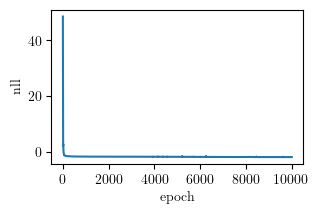

Best mll: 1.6626627


In [7]:
k = config['curve_params']['k']

rng_key = random.PRNGKey(config['rng_seed'])
rng_key, init_key = random.split(rng_key)
model = MLPModel(**config['curve_params']['model_kwargs'])
s_model = SubspaceModel(
    model, k, n_samples=config['curve_params']['n_samples'])
params = s_model.init_params(init_key, x)

# Train
lr = config['curve_params']['lr']
optimizer = optax.adamw(lr, weight_decay=config['curve_params']['weight_decay'])
opt_state = optimizer.init(params['params'])


losses = []
lengths = []
curvature = []
mean_lls = []
best_params = params
best_metric = -jnp.inf
mean_ll = get_mean_ll(s_model, x_val, y_val, jnp.linspace(0, 1, 500))

for i in tqdm(range(config['curve_params']['num_epochs'])):
    rng_key, subkey = random.split(rng_key)
    loss, params, opt_state = s_model.train_step(subkey, params, x, y, opt_state, optimizer)

    # get design matrix from curve parameters stroed as pytree
    cp_w = pytree_to_matrix(params['params'], k)
    # get curve length
    lengths.append(bezier_length(cp_w))
    curvature.append(mean_curvature(cp_w))
    losses.append(loss)
    # if i % 10 == 0:
    curve_performance = mean_ll(params)
    if curve_performance > best_metric:
        best_metric = curve_performance
        best_params = params
    mean_lls.append(curve_performance)

plt.plot(losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()
print("Best mll:", best_metric)

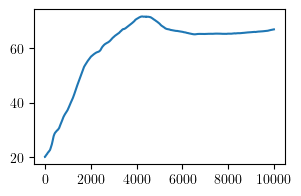

In [8]:
plt.plot(lengths)

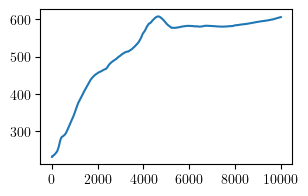

In [97]:
plt.plot(curvature)

In [9]:
cp_w.mean(0).shape

(261,)

### curvature analyse

#### Curvature in \( n \)-Dimensional Space

Given a parametric curve \( \mathbf{r}(t) \) in \( n \)-dimensional space, the curvature \( \kappa(t) \) is given by:

$$
\kappa(t) = \frac{ \sqrt{ \| \mathbf{r}'(t) \|^2 \| \mathbf{r}''(t) \|^2 - \left( \mathbf{r}'(t) \cdot \mathbf{r}''(t) \right)^2 } }{ \| \mathbf{r}'(t) \|^3 }
$$

Where:
- $ \mathbf{r}'(t) $ is the first derivative (velocity) of the curve.
- $ \mathbf{r}''(t) $ is the second derivative (acceleration) of the curve.
- $ \mathbf{r}'(t) \cdot \mathbf{r}''(t) $ is the dot product of the velocity and acceleration vectors.
- $ \| \mathbf{r}'(t) \| $ is the norm (magnitude) of the velocity vector.

#### Cross Product-Based Curvature Formula (2D or 3D)

In 2D or 3D, when dealing with vectors $ \mathbf{r}(t) $, the curvature can also be expressed using the cross product:

For 3D:

$$
\kappa(t) = \frac{ \| \mathbf{r}'(t) \times \mathbf{r}''(t) \| }{ \| \mathbf{r}'(t) \|^3 }
$$

For 2D, the cross product magnitude is simplified:

$$
\kappa(t) = \frac{ | x'(t) y''(t) - y'(t) x''(t) | }{ \left( (x'(t))^2 + (y'(t))^2 \right)^{3/2} }
$$

Where:
- $ \mathbf{r}'(t) \times \mathbf{r}''(t) $ is the cross product of the first and second derivatives (only defined in 3D).
- In 2D, $ x(t) $ and $ y(t) $ are the coordinate functions, and the curvature depends on their derivatives.


(2,) (2,)


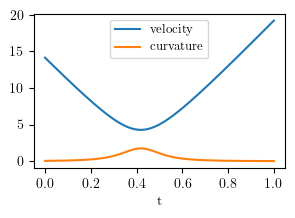

In [101]:
# 
def velocity(cp, tt):
    _, d_bezier = bezier_curve(cp.shape[0], cp)
    grad = jax.vmap(d_bezier)(tt)
    return jnp.linalg.norm(grad, axis=-1)

def mean_curvature1(cp, tt):
    _, d_bezier = bezier_curve(cp.shape[0], cp)
    def single(t):
        grad = d_bezier(t)
        second_dev = jax.jacrev(d_bezier)(t).squeeze()
        print(grad.shape, second_dev.shape)
        curvature = jnp.linalg.norm(
            jnp.cross(second_dev, grad)) / jnp.linalg.norm(grad)**3
        return curvature
    curvature = jax.vmap(single)(tt)
    return curvature


cp_test = jnp.array([[-3., -3.],
                            [-4., 4.],
                            [2., -3.5]])

tt = jnp.linspace(0, 1, 1000)
curveature = mean_curvature1(cp_test, tt)
velo = velocity(cp_test, tt)
plt.plot(tt, velo, label='velocity')
plt.plot(tt, curveature, label='curvature')
plt.xlabel('t')
plt.legend()

In [ ]:
@jit
def gyration(cp):
    cp_m = cp.mean(axis=0)
    return jnp.linalg.norm(cp - cp_m, axis=1).mean()


@jit
def gyration2(cp):
    cp_m = cp.mean(axis=0)
    return jnp.sqrt(jnp.power(cp - cp_m, 2).sum(axis=1).mean())

@jit
def mean_curvature(cp):
    tt = jnp.linspace(0, 1, 1000)
    d_bezier = get_d_bezier(tt)
    d_bezier

gyration(cp_w)

Array(16.328888, dtype=float32)

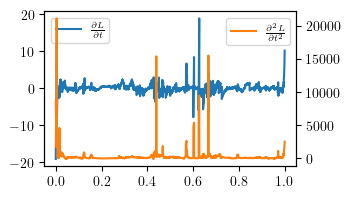

In [63]:
def get_loss(t):
    return s_model.nll(params, t, x, y).mean()

tt = jnp.linspace(0, 1, 10000).reshape(-1, 1)
grad = jax.vmap(jax.grad(get_loss))(tt).squeeze()
curvature = jax.vmap(jax.jacrev(jax.grad(get_loss)))(tt).squeeze()
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(tt, grad, label=r'$\frac{\partial{L}}{\partial t}$')
ax2.plot(tt, curvature,
         label=r'$\frac{\partial^2{L}}{\partial t^2}$', c=plt.get_cmap('tab10')(1))
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

In [92]:
@jit
def mean_curvature(cp):
    tt = jnp.linspace(0, 1, 1000)
    _, d_bezier = bezier_curve(cp.shape[0], cp)
    curvature = jax.vmap(jax.jacrev(d_bezier))(tt).squeeze()
    curvature_norm = jnp.linalg.norm(curvature, axis=-1)
    return jax.scipy.integrate.trapezoid(curvature_norm, tt)

mean_curvature(cp_w)

Array(606.27203, dtype=float32)

In [69]:
d_bezier = get_d_bezier(tt)
d_t = jnp.linalg.norm(d_bezier(cp_w), axis=-1)
d_t.shape

(10000,)

In [79]:
curve, dd_bezier = bezier_curve(cp_w.shape[0], cp_w)
d_bezier_tt = jax.vmap(jax.jacrev(jax.jacrev(curve)))(tt)
d_bezier_tt

(10000, 261, 1, 1)

Text(0.5, 0, 't')

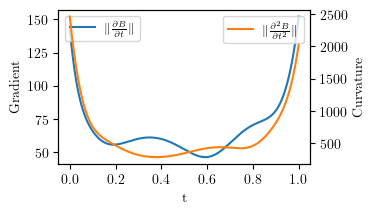

In [199]:
curve, dd_bezier = bezier_curve(cp_w.shape[0], cp_w)
d_bezier_tt = jax.vmap(jax.jacrev(dd_bezier))(tt).squeeze()
grad_norm = jnp.linalg.norm(jax.vmap(dd_bezier)(tt), axis=-1)
curvature_norm = jnp.linalg.norm(d_bezier_tt, axis=-1)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(tt, grad_norm, label=r'$\|\frac{\partial{B}}{\partial t}\|$')
ax2.plot(tt, curvature_norm,
         label=r'$ \| \frac{\partial^2{B}}{\partial t^2} \|$', c=plt.get_cmap('tab10')(1))
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel("Curvature")
ax.set_ylabel("Gradient")
ax.set_xlabel("t")

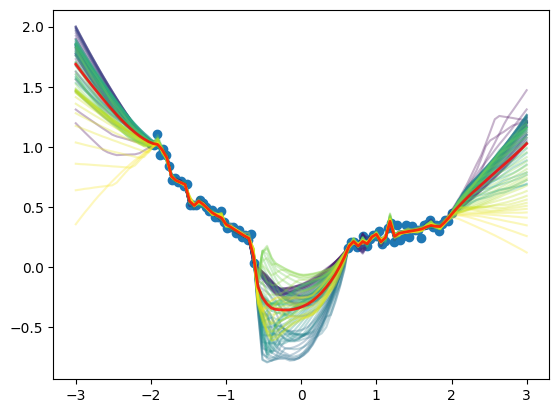

In [359]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)

### Loss Barier

Mean Log Likelihood train: 1.5224361419677734
Mean Log Likelihood val: 1.662374496459961
Mean Log Likelihood test: -113.26061248779297


Text(0.5, 1.0, 'Last model')

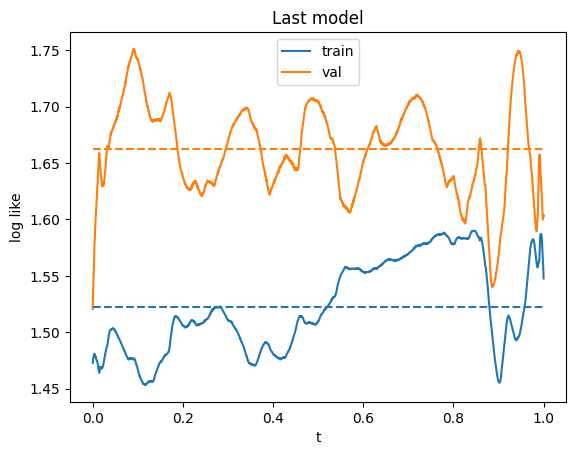

In [360]:
t_space = jnp.linspace(0.0, 1.0, 2000)
train_nll = -s_model.nll(best_params, t_space, x, y).mean(axis=-1)
val_nll = -s_model.nll(best_params, t_space, x_val, y_val).mean(axis=-1)
test_nll = -s_model.nll(best_params, t_space, x_test, y_test).mean(axis=-1)

plt.plot(t_space, train_nll, label='train')
plt.plot(t_space, val_nll, label='val')
# plt.plot(t_space, test_nll, label='test')
plt.hlines(jnp.mean(train_nll), 0, 1, color=plt.get_cmap('tab10')(0), linestyle='--')
plt.hlines(jnp.mean(val_nll), 0, 1, color=plt.get_cmap('tab10')(1), linestyle='--')
# plt.hlines(jnp.mean(test_nll), 0, 1, color=plt.get_cmap('tab10')(2), linestyle='--')
plt.xlabel("t")
plt.ylabel("log like")
print(f"Mean Log Likelihood train: {jnp.mean(train_nll)}")
print(f"Mean Log Likelihood val: {jnp.mean(val_nll)}")
print(f"Mean Log Likelihood test: {jnp.mean(test_nll)}")
plt.legend()
plt.title("Last model")

Mean Log Likelihood train: 1.7162861824035645
Mean Log Likelihood val: 1.5215821266174316
Mean Log Likelihood test: -121.12690734863281


Text(0.5, 1.0, 'Last model')

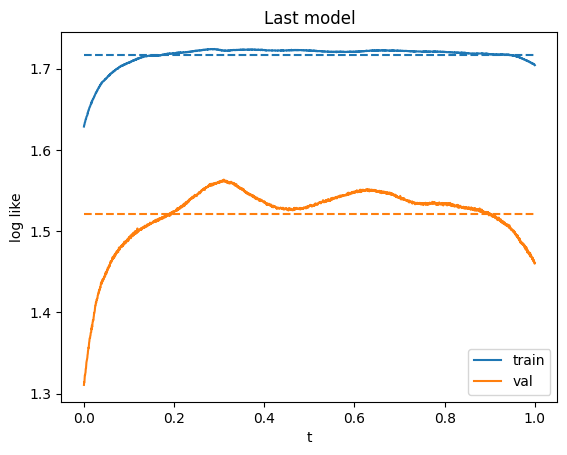

In [328]:
t_space = jnp.linspace(0.0, 1.0, 2000)
train_nll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
val_nll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
test_nll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)

plt.plot(t_space, train_nll, label='train')
plt.plot(t_space, val_nll, label='val')
# plt.plot(t_space, test_nll, label='test')
plt.hlines(jnp.mean(train_nll), 0, 1,
           color=plt.get_cmap('tab10')(0), linestyle='--')
plt.hlines(jnp.mean(val_nll), 0, 1,
           color=plt.get_cmap('tab10')(1), linestyle='--')
# plt.hlines(jnp.mean(test_nll), 0, 1, color=plt.get_cmap('tab10')(2), linestyle='--')
plt.xlabel("t")
plt.ylabel("log like")
print(f"Mean Log Likelihood train: {jnp.mean(train_nll)}")
print(f"Mean Log Likelihood val: {jnp.mean(val_nll)}")
print(f"Mean Log Likelihood test: {jnp.mean(test_nll)}")
plt.legend()
plt.title("Last model")

### reduce initial length by permutation control points

In [233]:
k = config['curve_params']['k']

rng_key = random.PRNGKey(config['rng_seed'])
rng_key, init_key = random.split(rng_key)
model = MLPModel(**config['curve_params']['model_kwargs'])
s_model = SubspaceModel(
    model, k, n_samples=config['curve_params']['n_samples'])
params = s_model.init_params(init_key, x)
cp_w = pytree_to_matrix(params, k)
bezier_length(cp_w)

Array(15.68073, dtype=float32)

In [244]:
# Step 2: Calculate the pairwise Euclidean distances
def euclidean_distance(p1, p2):
    return jnp.linalg.norm(p1 - p2)


# Compute the pairwise distance matrix using JAX's vectorized operations
distance_matrix = jax.vmap(lambda x: jax.vmap(
    lambda y: euclidean_distance(x, y))(cp_w))(cp_w)
# Set the diagonal elements to +inf
distance_matrix = distance_matrix.at[jnp.diag_indices_from(distance_matrix)].set(jnp.inf)
distance_matrix

Array([[      inf, 7.725629 , 7.8965144, 7.671597 , 7.9258375, 7.8851066],
       [7.725629 ,       inf, 7.9461365, 7.305871 , 7.3630285, 8.266869 ],
       [7.8965144, 7.9461365,       inf, 8.012352 , 7.433538 , 8.082803 ],
       [7.671597 , 7.305871 , 8.012352 ,       inf, 7.9558206, 8.369574 ],
       [7.9258375, 7.3630285, 7.433538 , 7.9558206,       inf, 8.323745 ],
       [7.8851066, 8.266869 , 8.082803 , 8.369574 , 8.323745 ,       inf]],      dtype=float32)

In [245]:
import scipy


row_idx, col_idx = scipy.optimize.linear_sum_assignment(distance_matrix, maximize=False)
distance_matrix[row_idx, col_idx]
per_cp_w = cp_w[col_idx]
bezier_length(per_cp_w)

Array(15.98657, dtype=float32)

In [273]:
# compute number of permutations
from math import factorial
factorial(cp_w.shape[0])    

720

In [247]:
import itertools

# Generate all permutations of the indices
# permutations = itertools.permutations(jnp.arange(cp_w.shape[0]))
range_ = jnp.arange(cp_w.shape[0])
s_e_permutations = itertools.combinations(range_, 2)
permutations = []
for start_end_p in s_e_permutations:
    print(jnp.array(start_end_p))
    missing = np.setdiff1d(range_, jnp.array(start_end_p))
    for miss in itertools.permutations(missing):
        permutations.append(
            np.array([start_end_p[0]] + list(miss) + [start_end_p[1]]))
print("Number of permutations: ", len(permutations))

# Initialize variables to store the best permutation and its length
best_permutation = None
min_length = float('inf')

# Loop through all permutations
for perm in tqdm(permutations):
    perm_cp_w = cp_w[jnp.array(perm)]
    length = bezier_length(perm_cp_w)
    if length < min_length:
        min_length = length
        best_permutation = jnp.array(perm)

print("Best permutation:", best_permutation)
print("Minimum length:", min_length)

[0 1]
[0 2]
[0 3]
[0 4]
[0 5]
[1 2]
[1 3]
[1 4]
[1 5]
[2 3]
[2 4]
[2 5]
[3 4]
[3 5]
[4 5]
Number of permutations:  360


100%|██████████| 360/360 [00:00<00:00, 939.57it/s]

Best permutation: [0 3 5 1 2 4]
Minimum length: 15.24057


100%|██████████| 10000/10000 [00:19<00:00, 517.53it/s]


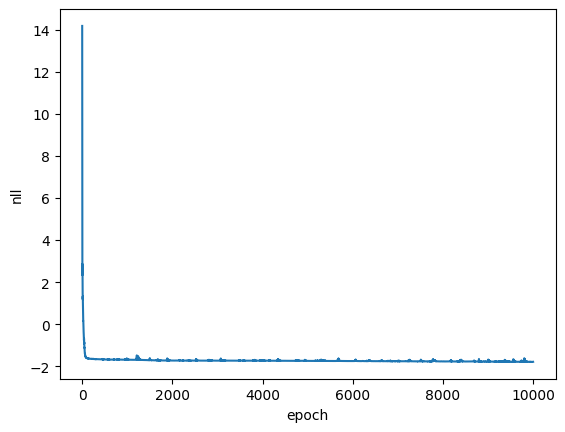

Best mll: 1.9077222


In [248]:
permutate_params = jax.tree.map(lambda x: x[best_permutation], params)
params = permutate_params

# Train
lr = config['curve_params']['lr']
optimizer = optax.adamw(lr, weight_decay=config['curve_params']['weight_decay'])
opt_state = optimizer.init(params)


losses = []
lengths = []
mean_lls = []
best_params = params
best_metric = -jnp.inf

mean_ll = get_mean_ll(s_model, x_val, y_val, jnp.linspace(0, 1, 500))

for i in tqdm(range(config['curve_params']['num_epochs'])):
    rng_key, subkey = random.split(rng_key)
    loss, params, opt_state = s_model.train_step(subkey, params, x, y, opt_state, optimizer)

    # get design matrix from curve parameters stroed as pytree
    cp_w = pytree_to_matrix(params, k)
    # get curve length
    lengths.append(bezier_length(cp_w))
    losses.append(loss)
    # if i % 10 == 0:
    curve_performance = mean_ll(params)
    if curve_performance > best_metric:
        best_metric = curve_performance
        best_params = params
    mean_lls.append(curve_performance)

plt.plot(losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()
print("Best mll:", best_metric)

In [ ]:
# jnp.save('params.npy', params)
# jnp.load('params.npy', allow_pickle=True).item()

Text(0.5, 0, 'epoch')

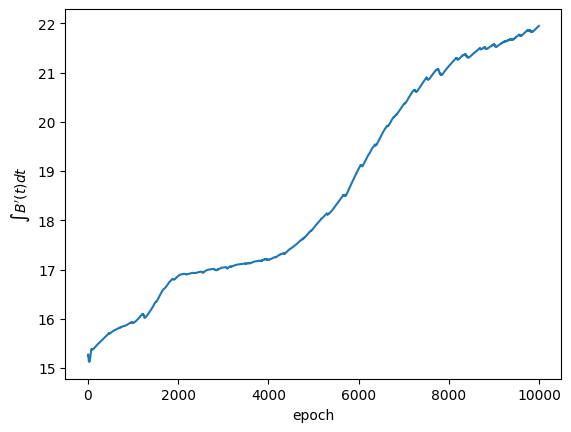

In [249]:
plt.plot(lengths)
plt.ylabel(f"$\int B'(t) dt$")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

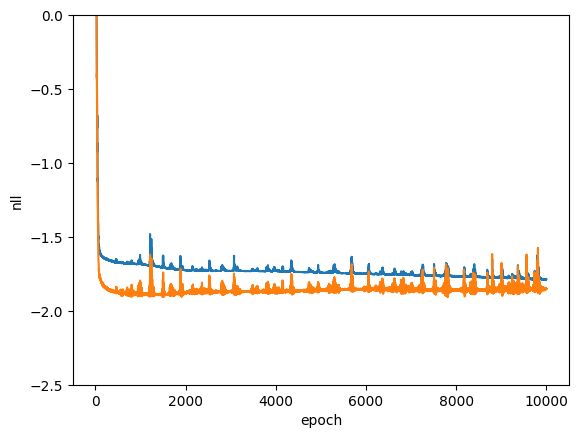

In [250]:
# use the same resolution as in pytorch
plt.plot(jnp.array(losses))
plt.plot(jnp.arange(len(mean_lls)), -jnp.array(mean_lls))
plt.ylim(-2.5, 0)
plt.ylabel("nll")
plt.xlabel("epoch")

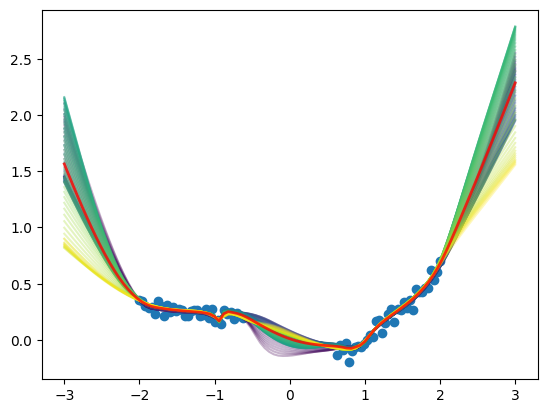

In [251]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(best_params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean',
         c='red', linewidth=2, alpha=0.8)

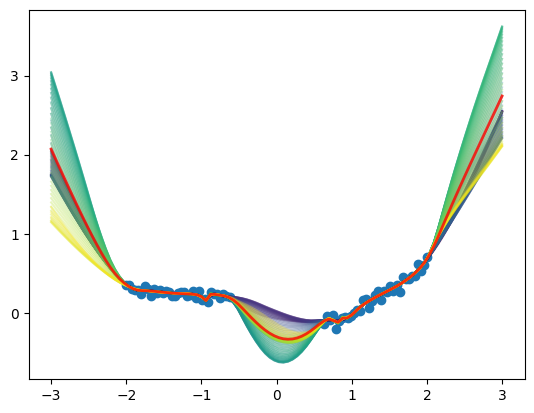

In [252]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)

#### Loss Barier

Mean Log Likelihood train: 1.788999319076538
Mean Log Likelihood val: 1.8501092195510864
Mean Log Likelihood test: -210.7855987548828


Text(0.5, 1.0, 'Last model')

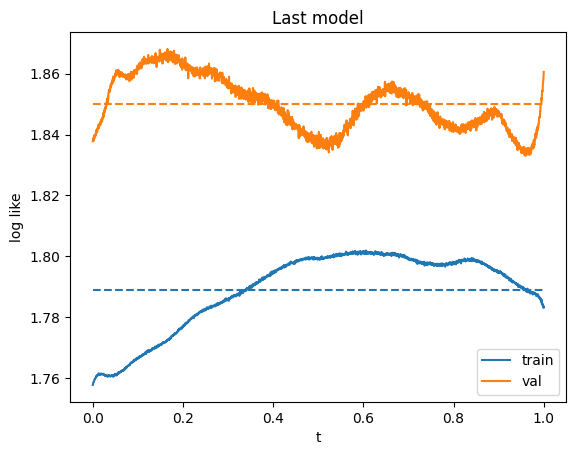

In [255]:
t_space = jnp.linspace(0.0, 1.0, 2000)
train_nll = -s_model.nll(best_params, t_space, x, y).mean(axis=-1)
val_nll = -s_model.nll(best_params, t_space, x_val, y_val).mean(axis=-1)
test_nll = -s_model.nll(best_params, t_space, x_test, y_test).mean(axis=-1)

plt.plot(t_space, train_nll, label='train')
plt.plot(t_space, val_nll, label='val')
# plt.plot(t_space, test_nll, label='test')
plt.hlines(jnp.mean(train_nll), 0, 1,
           color=plt.get_cmap('tab10')(0), linestyle='--')
plt.hlines(jnp.mean(val_nll), 0, 1,
           color=plt.get_cmap('tab10')(1), linestyle='--')
# plt.hlines(jnp.mean(test_nll), 0, 1, color=plt.get_cmap('tab10')(2), linestyle='--')
plt.xlabel("t")
plt.ylabel("log like")
print(f"Mean Log Likelihood train: {jnp.mean(train_nll)}")
print(f"Mean Log Likelihood val: {jnp.mean(val_nll)}")
print(f"Mean Log Likelihood test: {jnp.mean(test_nll)}")
plt.legend()
plt.title("Last model")

Mean Log Likelihood train: 1.7247318029403687
Mean Log Likelihood val: 1.9077844619750977
Mean Log Likelihood test: -176.2471923828125


Text(0.5, 1.0, 'Last model')

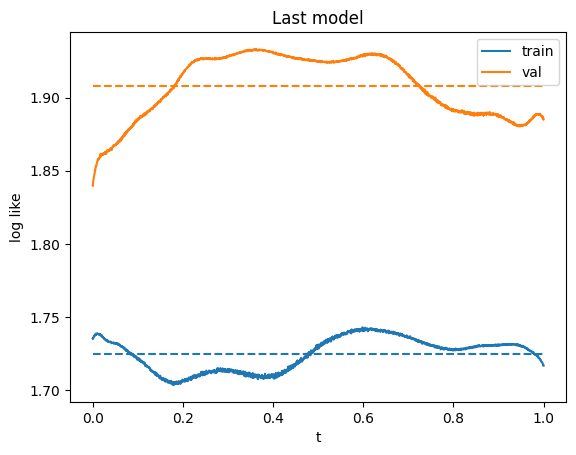

In [256]:
t_space = jnp.linspace(0.0, 1.0, 2000)
train_nll = -s_model.nll(params, t_space, x, y).mean(axis=-1)
val_nll = -s_model.nll(params, t_space, x_val, y_val).mean(axis=-1)
test_nll = -s_model.nll(params, t_space, x_test, y_test).mean(axis=-1)

plt.plot(t_space, train_nll, label='train')
plt.plot(t_space, val_nll, label='val')
# plt.plot(t_space, test_nll, label='test')
plt.hlines(jnp.mean(train_nll), 0, 1,
           color=plt.get_cmap('tab10')(0), linestyle='--')
plt.hlines(jnp.mean(val_nll), 0, 1,
           color=plt.get_cmap('tab10')(1), linestyle='--')
# plt.hlines(jnp.mean(test_nll), 0, 1, color=plt.get_cmap('tab10')(2), linestyle='--')
plt.xlabel("t")
plt.ylabel("log like")
print(f"Mean Log Likelihood train: {jnp.mean(train_nll)}")
print(f"Mean Log Likelihood val: {jnp.mean(val_nll)}")
print(f"Mean Log Likelihood test: {jnp.mean(test_nll)}")
plt.legend()
plt.title("Last model")